# Enhancing VAE Performance with BYOL: Self-Supervised Learning for Improved Image Inpainting

1. **Dane wejściowe**

    W zadaniu wykorzystany zostanie zbiór [Nature](https://www.kaggle.com/datasets/heyitsfahd/nature). Posiada on 100 956 obrazów o rozmiarach 64x64 i kolorze RGB, które należą do 4 klas: Miasto, Góry, Ogień i Jezior. Oprócz tego zostaną wygenerowane dodatkowe *uszkodzone* obrazy, czyli *oryginalne* zdjęcia z nałożonym w losowym miejscu czarnym kwadratem symbolizującym ubytek.

    Wejście do modelu będzie stanowić: X - zdjęcie *uszkodzone*, a uczony on będzie przy pomocy: Y - zdjęcie *oryginalne*.

2. **Dane wyjściowe**

    Na wyjściu autokodera zostanie wygenerowane zdjęcie uzupełnione, które będzie dążyć do maksymalnej zgodności z *oryginalnym* obrazem Y.

3. **Cel**

    Celem jest `inpainting` - zadanie rekonstrukcji obrazu, w którym brakujące fragmenty lub uszkodzone obszary zdjęć są uzupełniane w sposób zgodny z otaczającym kontekstem, tak aby uzyskać wizualnie spójny i realistyczny obraz.

4. **Hipoteza badawcza**

    Zastosowanie metody `Bootstrap Your Own Latent (BYOL)` do treningu enkodera modelu `Variational Autoencoder (VAE)` doprowadzi do poprawy jego wydajności w zadaniu inpaintingu obrazów.

5. **Opis metod**

    ![Architektura BYOL](resources\byol_architecture.png) \
    *Grafika z [publikacji](https://arxiv.org/pdf/2006.07733)*

    `Bootstrap Your Own Latent (BYOL)` - [Bootstrap Your Own Latent A New Approach to Self-Supervised Learning](https://arxiv.org/pdf/2006.07733) - to metoda samo-nadzorowanego uczenia maszynowego używana do trenowania modeli bez potrzeby etykietowania danych. Model tworzy dwie wersje danych wejściowych poprzez losowe augmentacje, które są następnie przetwarzane przez dwa enkodery: online i target. Reprezentacje uzyskane z tych enkoderów są przetwarzane przez prostą sieć MLP, która pełni rolę projektora, a w przypadku sieci online dodatkowo przez drugą sieć pełniącą rolę predyktora. Model stara się dopasować tak otrzymane reprezentacje poprzez minimalizowanie różnicy między nimi.


    `Variational Autoencoder (VAE)` - [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114) - to metoda generatywnego uczenia maszynowego, która koduje dane wejściowe jako średnie i wariancje rozkładu w przestrzeni ukrytej. VAE używa triku reparametryzacji, aby umożliwić propagację gradientów podczas trenowania, generując próbki z otrzymanego rozkładu. Następnie dekoder rekonstruuje dane, minimalizując różnicę między oryginałem a rekonstrukcją i regularizując przestrzeń ukrytą.

6. **Proces uczenia**

    Enkoder modelu `VAE` jest poddawany dostosowanej metodzie `BYOL` w celu wstępnego wytrenowania na zaugmentowanych obrazach oryginalnych. Aby wykorzystać otrzymany rozkład w przestrzeni ukrytej, stosowany jest trik reparametryzacyjny. Następnie tak wytrenowany enkoder jest dodawany do nowego modelu VAE, który jest dalej trenowany na zadaniu inpaintingu. Podczas treningu model jest regularnie walidowany na zbiorze danych walidacyjnych.

7. **Opis eksperymentów**

    Na podstawie zdjęć oryginalnych ze zbioru danych utworzone zostały zdjęcia uszkodzone poprzez umieszczenie w losowym miejscu czarnych prostokątów o lsowych wymiarach z zakresu (1/5, 1/4) rozmiaru zdjęcia. Tak uzyskane pary zdjęć w zbiorze danych, podzielone zostały an zbiór treningowy (70%), zbiór walidacyjny (15%) oraz zbiór testowy (15%). Dodatkowo w takcie tworzenia modelu zdjęcia zostją normalizowane do zakresu (-1, 1).

8. **Metryki**

    - **SSIM** - *Structural Similarity Index Measure* - metryka oceny jakości obrazu, która mierzy podobieństwo między dwoma obrazami, uwzględniając zmiany kontrastu i struktury.
    - **PSNR** - *Peak Signal-to-Noise Ratio* - oblicza stosunek maksymalnej możliwej mocy sygnału do mocy zakłócającego szumu, co wskazuje na poziom zniekształceń obrazu.
    - **MSE** - różnica między originalnym obrazem, a obrazem wygenerowanym.
    - **NRMSE** - *Normalized Root Mean Squared Error* - mierzy różnicę między oryginalnym a zrekonstruowanym obrazem, normalizując błąd średniokwadratowy przez zakres lub średnią wartość pikseli.

9. **Badanie wpływu hiperparametru**

    W zadaniu badany będzie wpływ hiperparametru `lambda_kl` na efektywność uczenia się metody `BYOL`. Parametr `lambda_kl` reguluje znaczenie **straty KL** w całkowitej funkcji straty, która wpływa na sposób, w jaki model równoważy optymalizację reprezentacji cech z zachowaniem struktury przestrzeni ukrytej modelu `VAE`.


## Imports

In [3]:
import copy
import os
import pickle
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [4]:
data_dir = "data"  # directory where data will be saved 

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You will be using {device.type}")

You will be using cuda


## Data Loading

### Data from JPG

In [ ]:
class PairedImagesDataset(Dataset):
    """
    A PyTorch Dataset for loading paired images from directories.

    This Dataset loads paired images (corrupted and original) from directories.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.
    class_dirs : list
        The list of class directories.
    file_pairs : list
        The list of file pairs.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.transform = transform
        self.class_dirs = sorted(os.listdir(corrupted_dir))

        # Ensure the two directories have the same number of class directories
        assert len(self.class_dirs) == len(os.listdir(original_dir))

        self.file_pairs = [
            (class_dir, filename)
            for class_dir in self.class_dirs
            for filename in sorted(os.listdir(os.path.join(corrupted_dir, class_dir)))
        ]

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.file_pairs)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        class_dir, filename = self.file_pairs[idx]

        # Load the corrupted and original images
        img_corrupted = Image.open(self.corrupted_dir / class_dir / filename)
        img_original = Image.open(self.original_dir / class_dir / filename)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [ ]:
class PairedImagesDataModule(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from directories.

    This DataModule loads paired images (corrupted and original) from directories
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDataset(
                self.corrupted_dir / "train",
                self.original_dir / "train",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDataset(
                self.corrupted_dir / "val",
                self.original_dir / "val",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDataset(
                self.corrupted_dir / "test",
                self.original_dir / "test",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=-1,
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val, batch_size=self.batch_size, num_workers=-1
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test, batch_size=self.batch_size, num_workers=-1
        )

In [ ]:
original_dir = Path("data/divided_x64")
corrupted_dir = Path("data/augmented_x64")

data_module = PairedImagesDataModule(corrupted_dir, original_dir, batch_size=32)
data_module.setup()

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

### Data from Pickle

In [5]:
class PairedImagesDatasetPickle(Dataset):
    """
    A PyTorch Dataset for loading paired images from pickle files.

    This Dataset loads paired images (corrupted and original) from pickle files.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_file : Path
        The pickle file containing the corrupted images.
    original_file : Path
        The pickle file containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_file: Path, original_file: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_file : Path
            The pickle file containing the corrupted images.
        original_file : Path
            The pickle file containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_file = corrupted_file
        self.original_file = original_file
        self.transform = transform

        # Load the images from the pickle files
        with open(corrupted_file, "rb") as f:
            self.corrupted_images = pickle.load(f)
        with open(original_file, "rb") as f:
            self.original_images = pickle.load(f)

        # Ensure the two files have the same number of images
        assert len(self.corrupted_images) == len(self.original_images)

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.corrupted_images)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        img_corrupted = self.corrupted_images[idx]
        img_original = self.original_images[idx]

        # Convert the numpy arrays to PIL Images
        img_corrupted = Image.fromarray(img_corrupted)
        img_original = Image.fromarray(img_original)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [6]:
class PairedImagesDataModulePickle(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from pickle files.

    This DataModule loads paired images (corrupted and original) from pickle files
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images pickle files.
    original_dir : Path
        The directory containing the original images pickle files.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images in pickle files.
        original_dir : Path
            The directory containing the original images in pickle files.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDatasetPickle(
                self.corrupted_dir / "train.pkl",
                self.original_dir / "train.pkl",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDatasetPickle(
                self.corrupted_dir / "val.pkl",
                self.original_dir / "val.pkl",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDatasetPickle(
                self.corrupted_dir / "test.pkl",
                self.original_dir / "test.pkl",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

In [7]:
original_dir = Path(f"{data_dir}/divided_x64")
corrupted_dir = Path(f"{data_dir}/augmented_x64")

data_module_pickle = PairedImagesDataModulePickle(
    corrupted_dir, original_dir, batch_size=512
)
data_module_pickle.setup()

train_loader = data_module_pickle.train_dataloader()
val_loader = data_module_pickle.val_dataloader()
test_loader = data_module_pickle.test_dataloader()

## Model

### VAE

In [8]:
class VAEEncoder(nn.Module):
    """
    Variational Autoencoder (VAE) Encoder module.

    Parameters
    ----------
    input_channels : int, optional
        Number of input channels, by default 3
    latent_dim : int, optional
        Dimension of the latent space, by default 32
    """

    def __init__(self, input_channels: int = 3, latent_dim: int = 32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
        )

        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the encoder.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            Mean and log variance of the latent space
        """
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from the latent space distribution.

        Parameters
        ----------
        mu : torch.Tensor
            Mean of the latent space
        log_var : torch.Tensor
            Log variance of the latent space

        Returns
        -------
        torch.Tensor
            Sample from the latent space
        """
        log_var = torch.clamp(log_var, min=-5, max=5)
        std = torch.exp(0.5 * log_var + 1e-7)
        eps = torch.randn_like(std)
        return mu + eps * std


In [9]:
class VariationalAutoencoder(nn.Module):
    """
    Variational Autoencoder (VAE) module.

    Parameters
    ----------
    encoder : nn.Module
        Encoder module
    input_channels : int, optional
        Number of input channels, by default 3
    latent_dim : int, optional
        Dimension of the latent space, by default 32
    """

    def __init__(self, encoder, input_channels: int = 3, latent_dim: int = 32):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = encoder

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 8 * 8 * 128),
            nn.LeakyReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the VAE.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Reconstructed input, mean and log variance of the latent space
        """
        mu, log_var = self.encoder(x)
        z = self.encoder.reparameterize(mu, log_var)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the decoder.

        Parameters
        ----------
        z : torch.Tensor
            Latent space tensor

        Returns
        -------
        torch.Tensor
            Reconstructed input
        """
        x_hat = self.decoder(z)
        return x_hat

    @staticmethod
    def loss_function(y: torch.Tensor, x_hat: torch.Tensor, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """
        Computes the VAE loss function, which is a combination of the reconstruction loss and the KL divergence.

        The reconstruction loss measures how well the decoder is doing at reconstructing the original input image.
        It is computed as the mean squared error (MSE) between the original image and the reconstructed image.

        The KL divergence measures how much the learned latent distribution deviates from a standard normal distribution.
        It is used to enforce the constraint that the latent distribution is a normal distribution.

        Parameters
        ----------
        y : torch.Tensor
            Original input
        x_hat : torch.Tensor
            Reconstructed input
        mu : torch.Tensor
            Mean of the latent space
        log_var : torch.Tensor
            Log variance of the latent space

        Returns
        -------
        torch.Tensor
            Loss value
        """
        recon_loss = nn.MSELoss(reduction="sum")(x_hat, y)  # Reconstruction loss
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
        return recon_loss + kl_div


In [10]:
class VAETrainer(pl.LightningModule):
    """
    Trainer for Variational Autoencoder (VAE) model.

    Parameters
    ----------
    model : nn.Module
        The VAE model to be trained.
    lr : float, optional
        Learning rate for the optimizer, by default 1e-3
    """

    def __init__(self, model: nn.Module, lr: float = 1e-3) -> None:
        super().__init__()
        self.model = model
        self.lr = lr

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the VAE model.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Reconstructed input, mean and log variance of the latent space
        """
        x, mu, log_var = self.model(x)
        return x, mu, log_var

    def training_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        """
        Perform a training step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            The input and target tensors for the batch.
        batch_idx : int
            The index of the batch.

        Returns
        -------
        dict
            A dictionary with the loss for the step.
        """
        x, y = batch
        x, y= x.to(self.device), y.to(device)
        x_hat, mu, log_var = self.model(x)
        loss = self.model.loss_function(y, x_hat, mu, log_var)
        self.log("train_loss", loss)
        return loss

    def validation_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        """
        Perform a validation step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            The input and target tensors for the batch.
        batch_idx : int
            The index of the batch.

        Returns
        -------
        dict
            A dictionary with the loss for the step.
        """
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        x_hat, mu, log_var = self.model(x)
        loss = self.model.loss_function(y, x_hat, mu, log_var)
        self.log("val_loss", loss)
        print(f"Validation loss: {loss}")

        y_pred = x_hat[0].detach().cpu().numpy().transpose(1, 2, 0)
        y_pred = (y_pred + 1) / 2  # Normalize to [0, 1]
        y = y[0].detach().cpu().numpy().transpose(1, 2, 0)
        y = (y + 1) / 2  # Normalize to [0, 1]

        plt.style.use("default")
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(y_pred)
        axs[0].set_title("Predicted")
        axs[1].imshow(y)
        axs[1].set_title("Ground Truth")
        plt.suptitle(f"Epoch {self.current_epoch}")
        plt.show()

        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configure the optimizer for the model.

        Returns
        -------
        torch.optim.Optimizer
            The optimizer for the model.
        """
        return torch.optim.Adam(self.parameters(), lr=self.lr)

### BYOL

In [11]:
class BYOL(pl.LightningModule):
    """
    Bootstrapped Your Own Latent (BYOL) module.

    Parameters
    ----------
    encoder : nn.Module
        Encoder module
    latent_channels : int
        Number of latent channels
    learning_rate : float, optional
        Learning rate for the optimizer, by default 1e-4
    tau : float, optional
        Momentum for the target network update, by default 0.99
    out_channels : int, optional
        Number of output channels, by default 10
    lambda_byol : float, optional
        Weight for the BYOL loss, by default 1.0
    lambda_kl : float, optional
        Weight for the KL divergence loss, by default 0.5
    """

    def __init__(self, encoder, latent_channels: int, learning_rate: float = 1e-4, tau: float = 0.99,
                 out_channels: int = 10, lambda_byol: float = 1.0, lambda_kl: float = 0.5):
        super(BYOL, self).__init__()
        self.online_encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(latent_channels, latent_channels),
            nn.BatchNorm1d(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, latent_channels),
            nn.BatchNorm1d(latent_channels),
            nn.ReLU(),
        )
        self.predictor = nn.Sequential(
            nn.Linear(latent_channels, latent_channels),
            nn.BatchNorm1d(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, out_channels),
        )

        self.target_encoder = copy.deepcopy(encoder).eval()
        self.target_projector = copy.deepcopy(self.projector).eval()

        self.lr = learning_rate
        self.tau = tau
        self.lambda_byol = lambda_byol
        self.lambda_kl = lambda_kl

        self.augmentation = nn.Sequential(
            transforms.RandomApply([transforms.RandomRotation(degrees=(10, 60))], p=0.2),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.GaussianBlur((3, 3), (1.0, 2.0))], p=0.2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the BYOL model.

        The forward pass involves several steps:
        1. The input tensor `x` is passed through two different augmentations to generate `t` and `t_prim`.
        2. `t` and `t_prim` are passed through the online encoder to generate `q` and `q_prim` respectively.
        3. `q` and `q_prim` are then passed through the projector and predictor to generate the final predicted tensors.
        4. With the gradients turned off, `t` and `t_prim` are passed through the target encoder and target projector
           to generate the target tensors `z_target` and `z_target_prim`.
        5. The predicted tensors and target tensors are concatenated along the batch dimension.
        6. The KL divergence loss is computed for both `t` and `t_prim` and summed to get the final KL divergence loss.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Predicted tensor, target tensor, and KL divergence loss
        """
        x = x.to(self.device)
        t = self.augmentation(x)
        t_prim = self.augmentation(x)

        mu, log_var = self.online_encoder(t)
        q = self.online_encoder.reparameterize(mu, log_var)
        q = self.projector(q)
        q = self.predictor(q)

        mu_prim, log_var_prim = self.online_encoder(t_prim)
        q_prim = self.online_encoder.reparameterize(mu_prim, log_var_prim)
        q_prim = self.projector(q_prim)
        q_prim = self.predictor(q_prim)

        with torch.no_grad():
            z_target = self.target_encoder.reparameterize(*self.target_encoder(t))
            z_target = self.target_projector(z_target)

            z_target_prim = self.target_encoder.reparameterize(*self.target_encoder(t_prim))
            z_target_prim = self.target_projector(z_target_prim)

        q = torch.cat([q, q_prim], dim=0)
        z_target = torch.cat([z_target, z_target_prim], dim=0)

        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_loss_prim = -0.5 * torch.sum(1 + log_var_prim - mu_prim.pow(2) - log_var_prim.exp())
        kl_loss = kl_loss + kl_loss_prim

        return q, z_target, kl_loss

    def byol_loss(self, q: torch.Tensor, z_target: torch.Tensor, kl_loss: torch.Tensor) -> torch.Tensor:
        """
        Computes the BYOL loss.

        This function computes the BYOL loss, which combines similarity between predicted
        and target tensors using dot products, normalized to unit magnitude, and ensures
        Gaussian distribution of the latent space with a weighted sum of BYOL and KL divergence
        losses (lambda_byol and lambda_kl).

        Parameters
        ----------
        q : torch.Tensor
            Predicted tensor
        z_target : torch.Tensor
            Target tensor
        kl_loss : torch.Tensor
            KL divergence loss

        Returns
        -------
        torch.Tensor
            Loss value
        """
        q = nn.functional.normalize(q, dim=-1)
        z_target = nn.functional.normalize(z_target, dim=-1)

        loss_byol = 2 - 2 * (q * z_target).sum(dim=-1)
        loss = self.lambda_byol * loss_byol.mean() + self.lambda_kl * kl_loss

        return loss

    @torch.no_grad()
    def update_target(self):
        """
        Updates the target network parameters using a momentum-based update rule and the online network parameters.
        """
        for online_params, target_params in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            target_params.data = self.tau * target_params.data + (1 - self.tau) * online_params.data

        for online_params, target_params in zip(self.projector.parameters(), self.target_projector.parameters()):
            target_params.data = self.tau * target_params.data + (1 - self.tau) * online_params.data

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        """
        Performs a single training step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            Current batch of data
        batch_idx : int
            Index of the current batch

        Returns
        -------
        torch.Tensor
            Loss value
        """
        x, _ = batch
        x = x.to(self.device)
        q, z_target, kl_loss = self(x)
        loss = self.byol_loss(q, z_target, kl_loss)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        """
        Performs a single validation step.

        Parameters
        ----------
        batch : tuple
            Current batch of data
        batch_idx : int
            Index of the current batch

        Returns
        -------
        torch.Tensor
            Loss value
        """
        x, _ = batch
        x = x.to(self.device)
        q, z_target, kl_loss = self(x)
        loss = self.byol_loss(q, z_target, kl_loss)
        self.log("val_loss", loss)
        print(f"Val loss in epoch {self.current_epoch}: {loss}")

        return loss

    def on_train_epoch_end(self) -> None:
        """
        Callback function at the end of a training epoch, used to update the target network.
        """
        self.update_target()

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configure the optimizer for the model.

        Returns
        -------
        torch.optim.Optimizer
            The optimizer for the model.
        """
        return torch.optim.Adam(self.parameters(), lr=self.lr)


### Evaluate

In [12]:
def evaluate(model: nn.Module, test_loader: DataLoader) -> None:
    """
    Evaluate the model on a test dataset and display the results.

    This function computes the MSE, NRMSE, PSNR, and SSIM metrics for the model's predictions
    on the test dataset. It also displays the corrupted, predicted, and ground truth images
    for the first 5 samples in the test dataset.

    Parameters
    ----------
    model : nn.Module
        The model to evaluate.
    test_loader : DataLoader
        The DataLoader for the test dataset.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the computed metrics for each sample in the test dataset.
    """
    plt.style.use('default')
    model.eval()
    fig, axs = plt.subplots(3, 5, figsize=(15, 15))
    metrics = {"MSE": [], "NRMSE": [], "PSNR": [], "SSIM": []}
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x, y = x.to(model.device), y.to(model.device)
            y_pred, _, _ = model(x)
            y_pred = y_pred[0].detach().cpu().numpy().transpose(1, 2, 0)
            y_pred = (y_pred + 1) / 2
            y = y[0].detach().cpu().numpy().transpose(1, 2, 0)
            y = (y + 1) / 2
            x = x[0].detach().cpu().numpy().transpose(1, 2, 0)
            x = (x + 1) / 2

            mse = mean_squared_error(y.flatten(), y_pred.flatten())
            nrmse = np.sqrt(mse) / (np.max(y) - np.min(y))
            psnr = peak_signal_noise_ratio(y, y_pred, data_range=y.max() - y.min())
            ssim = structural_similarity(
                y, y_pred, channel_axis=-1, data_range=y.max() - y.min()
            )

            metrics["MSE"].append(mse)
            metrics["NRMSE"].append(nrmse)
            metrics["PSNR"].append(psnr)
            metrics["SSIM"].append(ssim)

            if idx < 5:
                axs[0, idx].imshow(x)
                axs[0, idx].set_title("Corrupted Image")
                axs[1, idx].imshow(y_pred)
                axs[1, idx].set_title("Predicted")
                axs[2, idx].imshow(y)
                axs[2, idx].set_title("Ground Truth")

    plt.show()

    metrics_df = pd.DataFrame(metrics)
    summary = metrics_df.describe()
    mean_min_summary = summary.loc[["max", "mean", "min"]]
    display(mean_min_summary)

    return metrics_df

## Train

In [ ]:
%load_ext tensorboard

%tensorboard --logdir lightning_logs/

In [13]:
EPOCHS = 30
LATENT_DIM = 64

### Default VAE

In [14]:
encoder = VAEEncoder(latent_dim=LATENT_DIM)

In [15]:
vae = VariationalAutoencoder(encoder, latent_dim=LATENT_DIM)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"The VAE model has {num_params} parameters.")

The VAE model has 4439299 parameters.


In [16]:
vae_trainer = VAETrainer(vae)
trainer_vae = pl.Trainer(
    accelerator=device.type,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=3,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 2480813.5


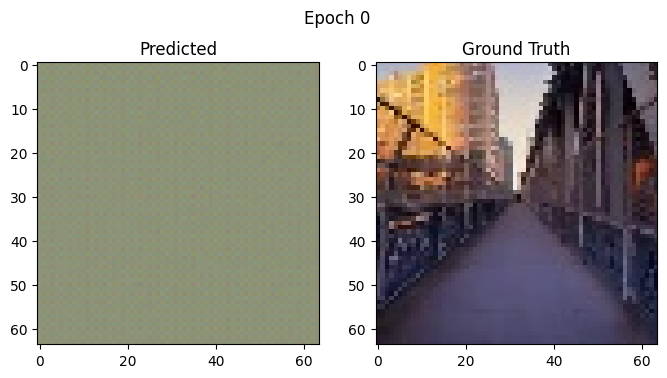

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 433854.53125


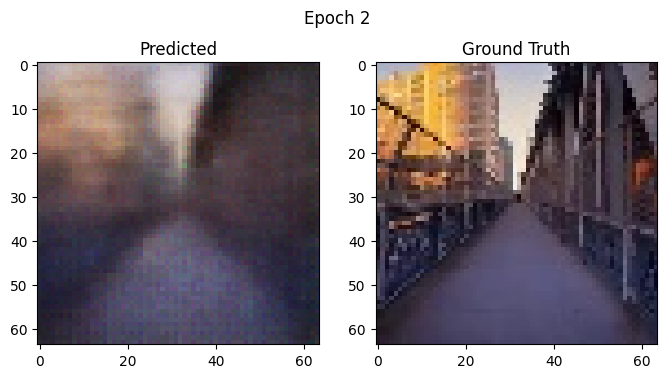

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 365336.46875


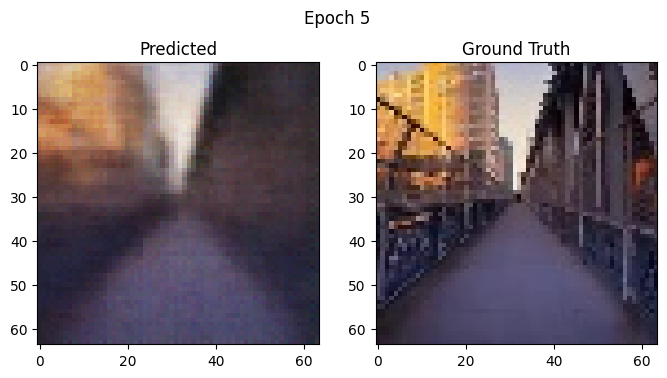

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 330297.9375


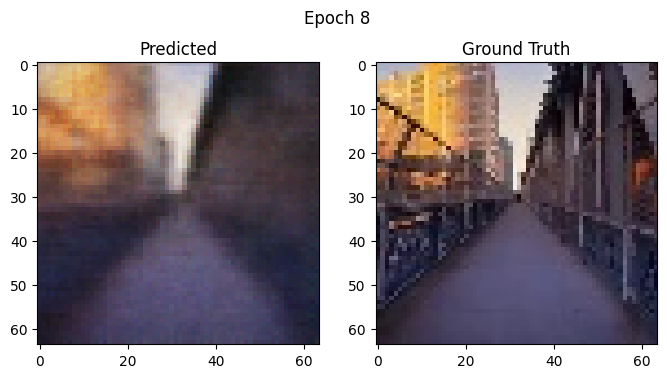

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 308203.5


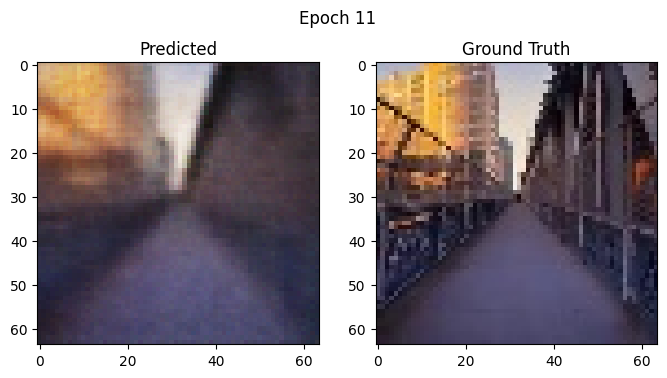

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 292702.8125


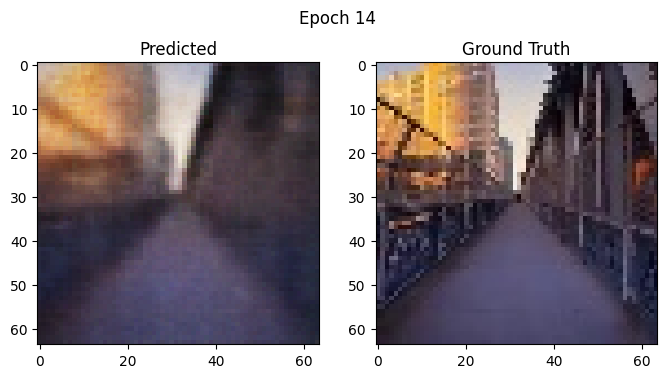

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 275503.40625


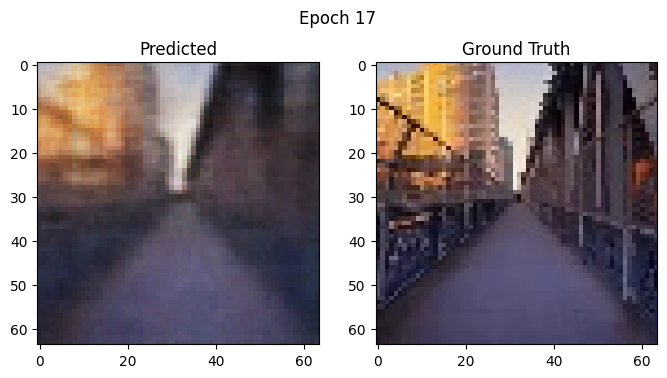

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 270378.25


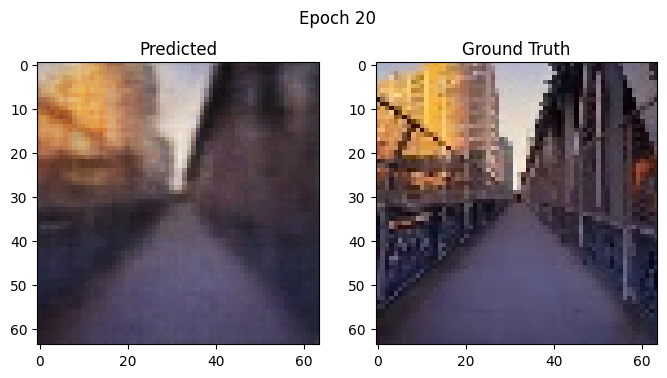

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 260656.796875


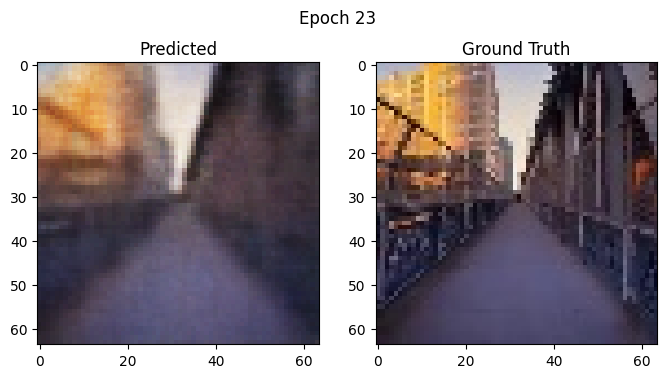

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 249094.671875


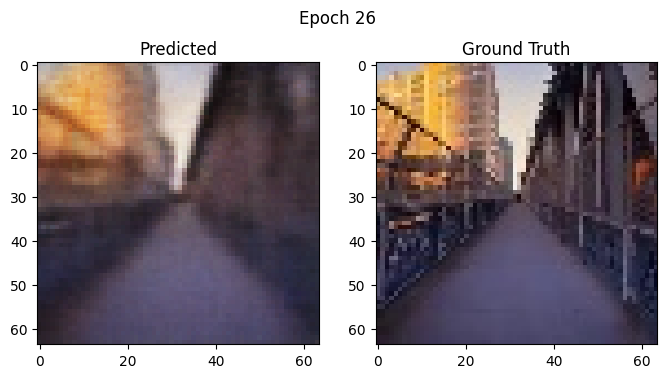

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 240685.84375


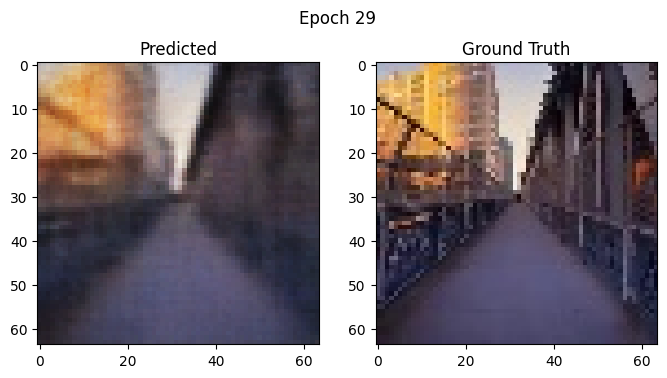

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [17]:
trainer_vae.fit(vae_trainer, train_loader, val_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


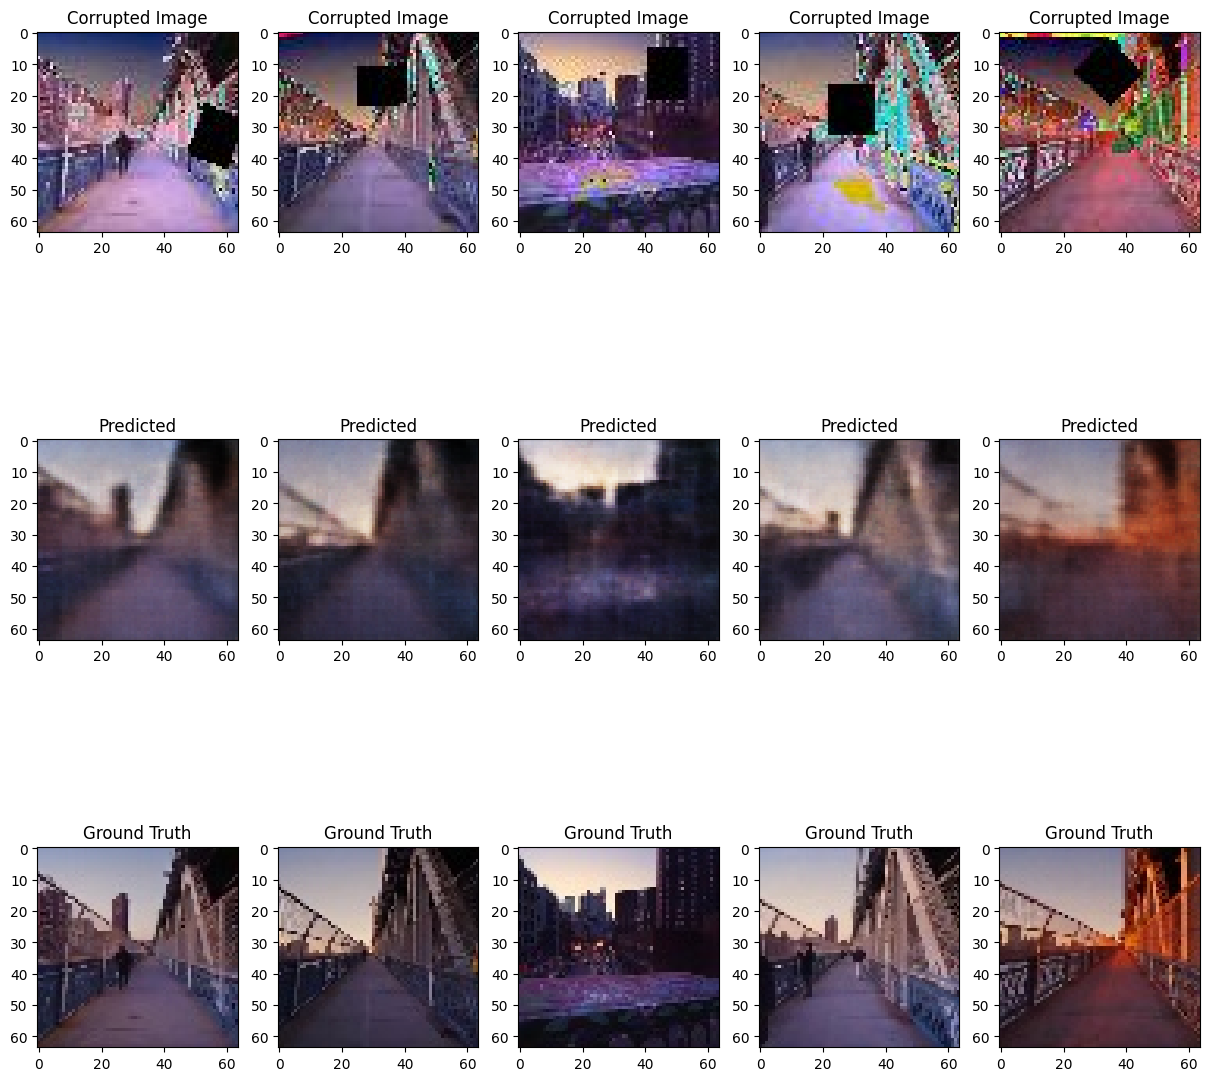

MSE     NRMSE       PSNR      SSIM
max   0.014829  0.128676  27.979726  0.929291
mean  0.007048  0.086434  21.667964  0.623682
min   0.001410  0.039904  17.810019  0.341300

In [18]:
vae_metrics = evaluate(vae_trainer, test_loader)

### BYOL - VAE

#### BYOL

In [19]:
encoder_byol = VAEEncoder(latent_dim=LATENT_DIM).to(device)

num_params = sum(p.numel() for p in encoder_byol.parameters())
print(f"Encoder Byol has {num_params} parameters.")

Encoder Byol has 2224000 parameters.


In [20]:
byol_trainer = BYOL(encoder_byol, latent_channels=LATENT_DIM, learning_rate=1e-4, tau=0.99, out_channels=LATENT_DIM,
                    lambda_kl=0.3)

In [21]:
trainer_byol = pl.Trainer(
    accelerator=device.type,
    max_epochs=15,
    check_val_every_n_epoch=1,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [22]:
trainer_byol.fit(byol_trainer, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | online_encoder   | VAEEncoder | 2.2 M  | train
1 | projector        | Sequential | 8.6 K  | train
2 | predictor        | Sequential | 8.4 K  | train
3 | target_encoder   | VAEEncoder | 2.2 M  | eval 
4 | target_projector | Sequential | 8.6 K  | eval 
5 | augmentation     | Sequential | 0      | train
--------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.894    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val loss in epoch 0: 23.019628524780273


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 0: 9.77380657196045


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 1: 2.878138542175293


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 2: 0.9804973602294922


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 3: 0.7226431369781494


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 4: 0.6930028796195984


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 5: 0.5987428426742554


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 6: 0.5857865810394287


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 7: 0.5658006072044373


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 8: 0.5484471917152405


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 9: 0.531503438949585


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 10: 0.5203948616981506


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 11: 0.5120768547058105


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 12: 0.5014356374740601


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 13: 0.503157377243042


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 14: 0.4950082004070282


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


#### VAE

In [23]:
vae_byol = VariationalAutoencoder(encoder_byol, latent_dim=LATENT_DIM).to(device)
num_params = sum(p.numel() for p in vae_byol.parameters())
print(f"Number of parameters: {num_params}")

vae_byol_trainer = VAETrainer(vae_byol, lr=1e-3)

Number of parameters: 4439299


In [24]:
trainer_vae_byol = pl.Trainer(
    accelerator=device.type,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=3,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation loss: 2196617.75


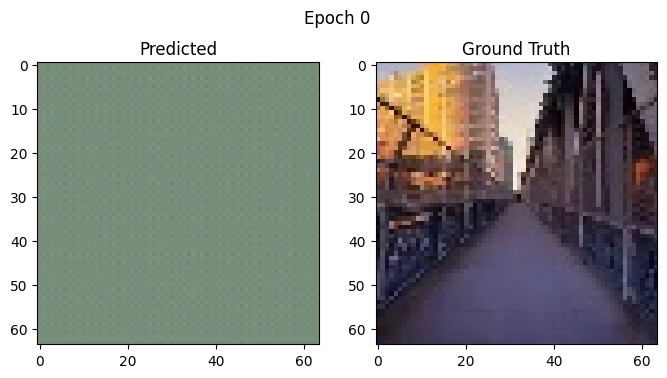

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 477031.625


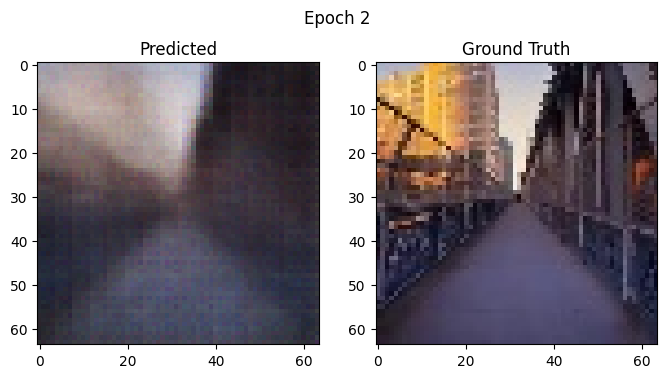

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 397354.375


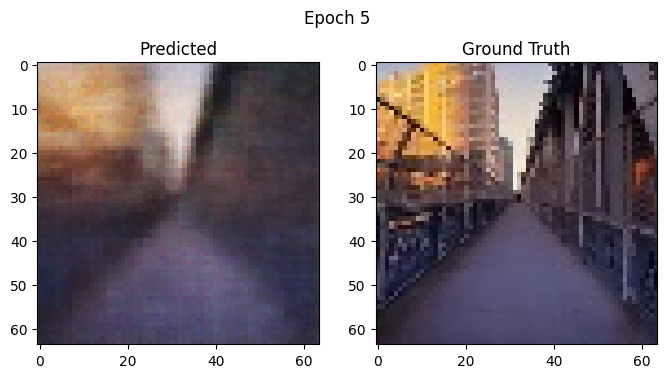

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 363186.1875


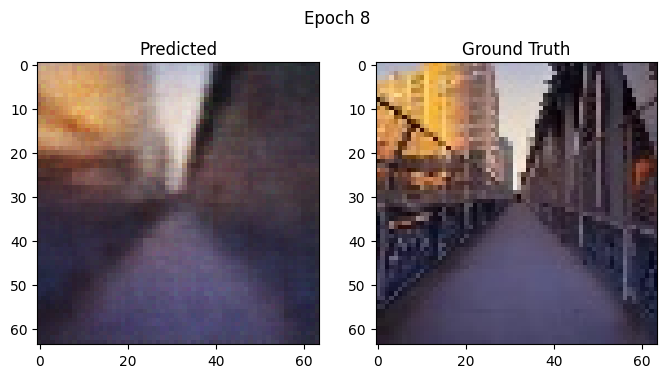

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 332215.0625


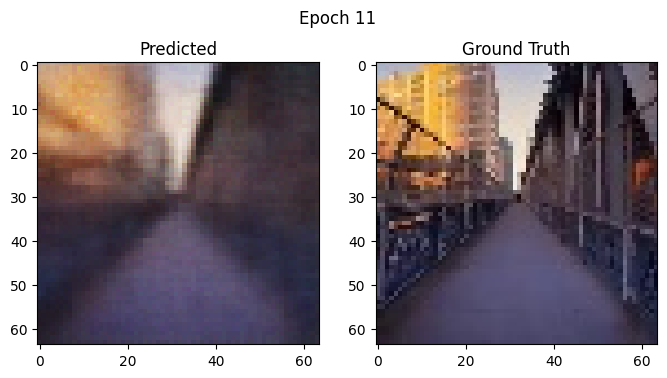

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 315370.4375


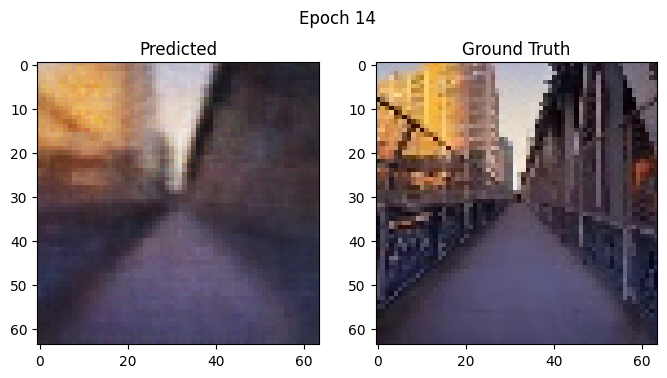

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 302861.375


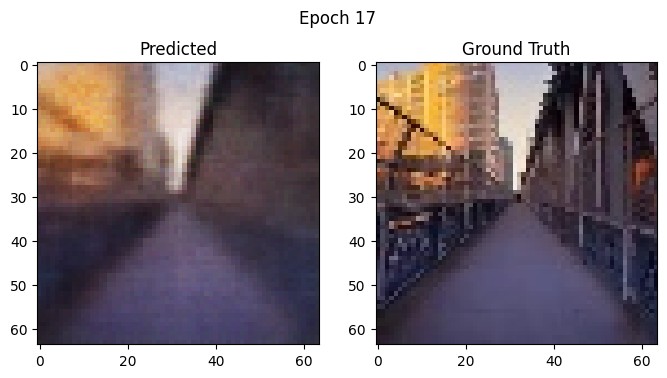

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 290231.0


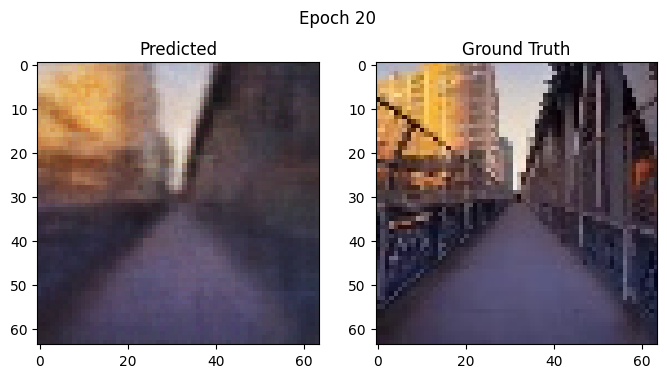

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 282501.78125


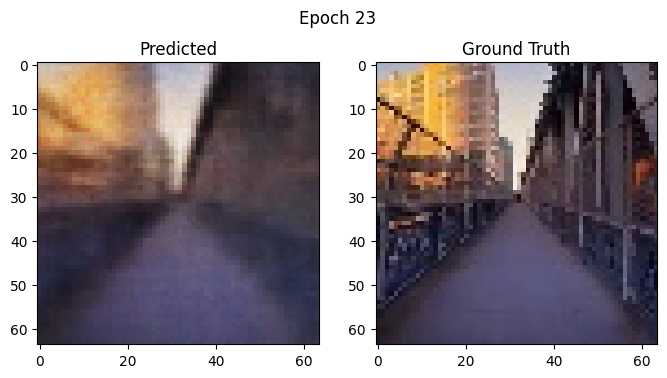

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 279702.6875


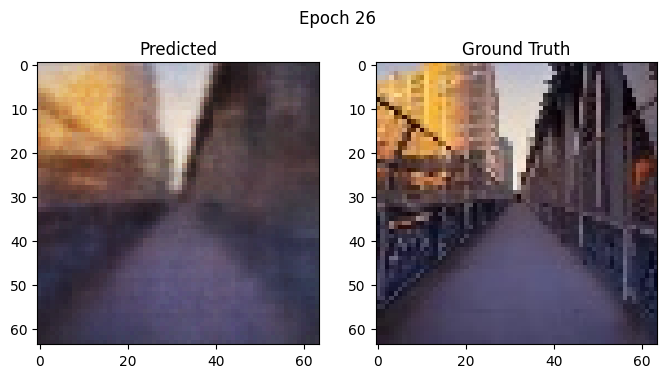

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 266398.25


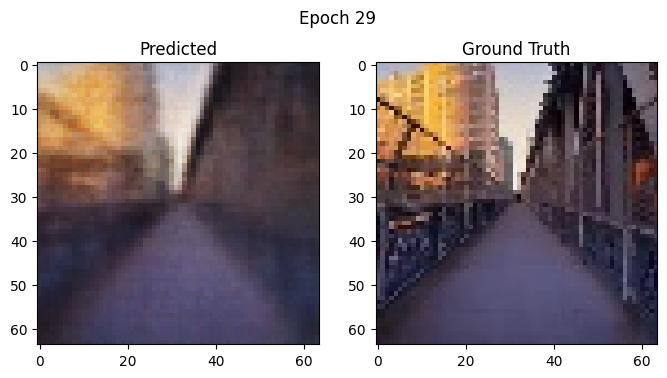

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [25]:
trainer_vae_byol.fit(vae_byol_trainer, train_loader, val_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


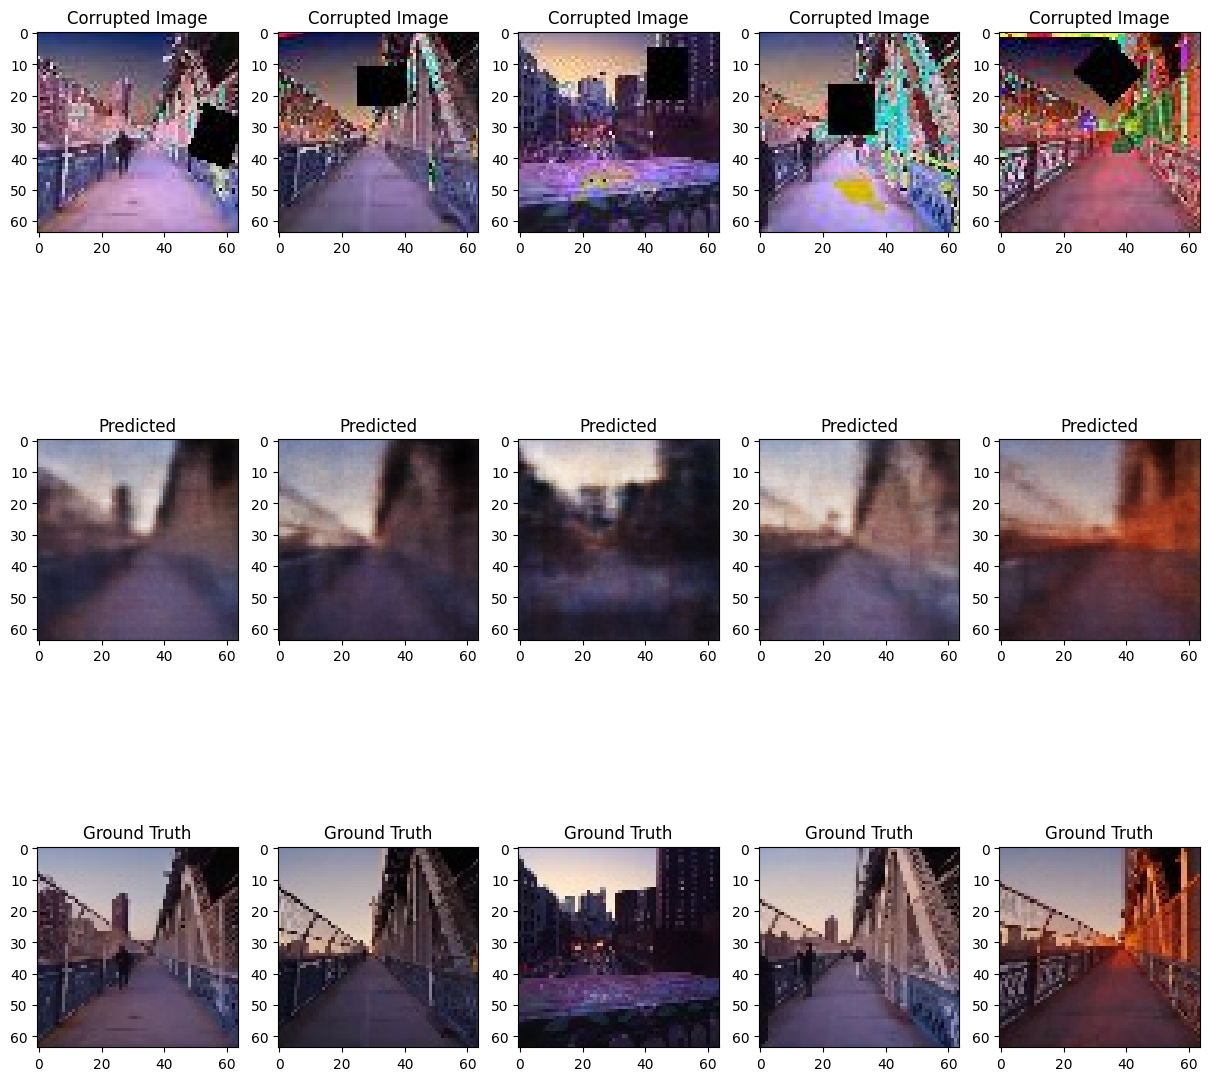

MSE     NRMSE       PSNR      SSIM
max   0.017869  0.137400  27.311293  0.920160
mean  0.008133  0.092503  21.109142  0.597923
min   0.001641  0.043096  17.240267  0.306129

In [26]:
vae_byol_metrics = evaluate(vae_byol_trainer, test_loader)

### VAE - BYOL - VAE

#### First VAE step

In [27]:
encoder_vbv = VAEEncoder(latent_dim=LATENT_DIM).to(device)

vae_vbv = VariationalAutoencoder(encoder_vbv, latent_dim=LATENT_DIM).to(device)

vae_vbv_trainer = VAETrainer(vae_vbv, lr=1e-3)

trainer_vae_vbv1 = pl.Trainer(
    accelerator=device.type,
    max_epochs=10,
    check_val_every_n_epoch=3,
    limit_val_batches=1,
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [ ]:
trainer_vae_vbv1.fit(vae_vbv_trainer, train_loader, val_loader)

In [ ]:
_ = evaluate(vae_vbv_trainer, test_loader)

#### BYOL step

In [30]:
byol_vbv_trainer = BYOL(encoder_vbv, latent_channels=LATENT_DIM, learning_rate=1e-4, tau=0.99, out_channels=LATENT_DIM,
                        lambda_kl=0)

trainer_byol_vbv = pl.Trainer(
    accelerator=device.type,
    max_epochs=15,
    check_val_every_n_epoch=1,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [ ]:
trainer_byol_vbv.fit(byol_vbv_trainer, train_loader, val_loader)

#### Second VAE step

In [32]:
trainer_vae_vbv2 = pl.Trainer(
    accelerator=device.type,
    max_epochs=20,
    check_val_every_n_epoch=3,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [ ]:
trainer_vae_vbv2.fit(vae_vbv_trainer, train_loader, val_loader)

In [ ]:
vbv_metrics = evaluate(vae_vbv_trainer, test_loader)

### Results

In [35]:
vae_metric = vae_metrics.describe().loc[["mean", "min", "max"]]
vae_byol_metric = vae_byol_metrics.describe().loc[["mean", "min", "max"]]
vbv_metric = vbv_metrics.describe().loc[["mean", "min", "max"]]

vae_metric['Model'] = 'VAE'
vae_byol_metric['Model'] = 'BYOL-VAE'
vbv_metric['Model'] = 'VAE-BYOL-VAE'

all_metrics = pd.concat([vae_metric, vae_byol_metric, vbv_metric])

display(all_metrics)

MSE     NRMSE       PSNR      SSIM         Model
mean  0.007048  0.086434  21.667964  0.623682           VAE
min   0.001410  0.039904  17.810019  0.341300           VAE
max   0.014829  0.128676  27.979726  0.929291           VAE
mean  0.008133  0.092503  21.109142  0.597923      BYOL_VAE
min   0.001641  0.043096  17.240267  0.306129      BYOL_VAE
max   0.017869  0.137400  27.311293  0.920160      BYOL_VAE
mean  0.007213  0.087028  21.630752  0.622849  VAE_BYOL_VAE
min   0.001514  0.040494  17.487582  0.318842  VAE_BYOL_VAE
max   0.014887  0.133543  27.852185  0.927195  VAE_BYOL_VAE

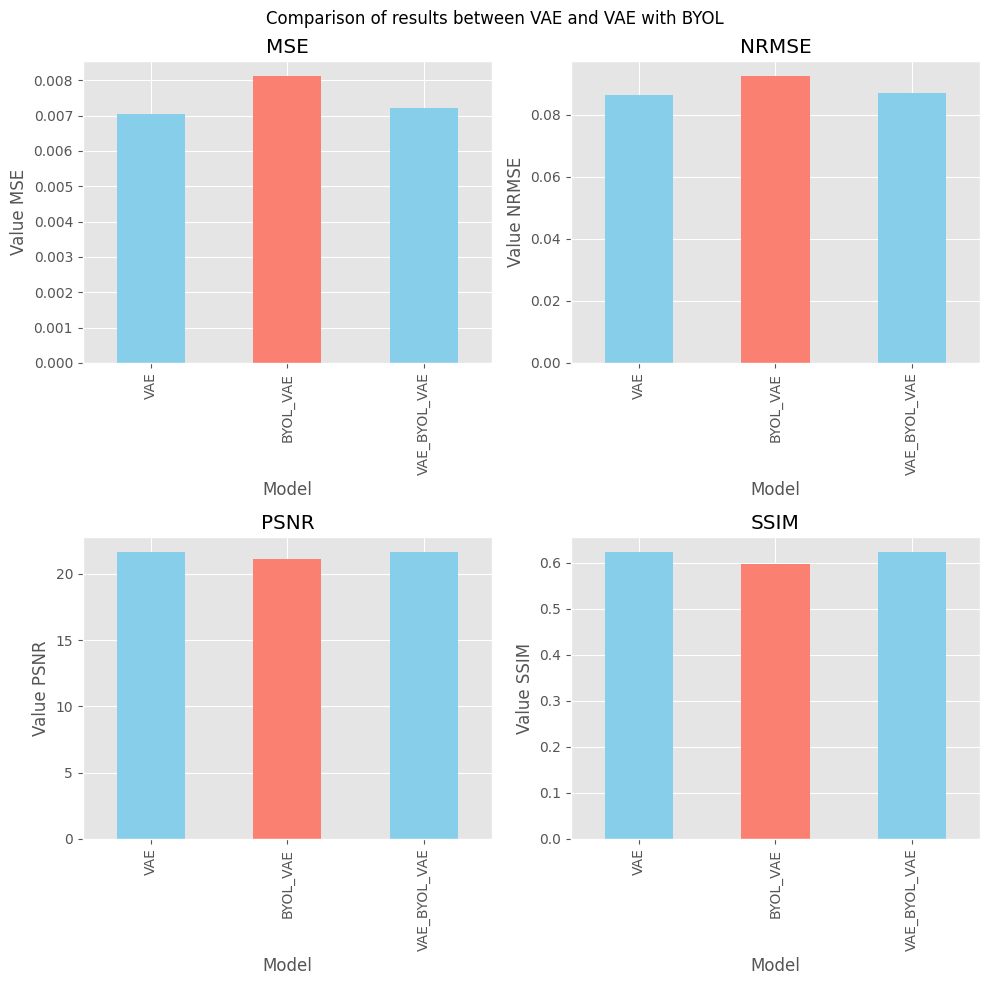

In [36]:
mean_metrics = all_metrics.loc['mean']
mean_metrics = mean_metrics.set_index('Model')

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for idx, metric in enumerate(mean_metrics.columns):
    mean_metrics[metric].plot(kind='bar', ax=axs[idx], title=metric, color=['skyblue', 'salmon'])
    axs[idx].set_xticklabels(mean_metrics.index, rotation=90)
    axs[idx].set_ylabel(f'Value {metric}')
    axs[idx].set_xlabel('Model')

plt.suptitle('Comparison of results between VAE, BYOL-VAE and VAE-BYOL-VAE')
plt.tight_layout()
plt.show()

## Experiment with KL Lambda

### BYOL - VAE

In [ ]:
def train_byol_vae(byol_epochs: int, vae_epochs: int, kl_lambda: float, latent_dim: int) -> pd.DataFrame:
    """
    Train the BYOL and VAE models and evaluate the results.

    Parameters
    ----------
    byol_epochs : int
        Number of epochs to train the BYOL model.
    vae_epochs : int
        Number of epochs to train the VAE model.
    kl_lambda : float
        Weight for the KL divergence loss in the VAE model.
    latent_dim : int
        Dimensionality of the latent space in the VAE model.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the mean evaluation metrics for the trained VAE model.

    """
    encoder = VAEEncoder(latent_dim=latent_dim).to(device)
    byol = BYOL(encoder, latent_channels=latent_dim, learning_rate=1e-4, tau=0.99, lambda_kl=kl_lambda,
                out_channels=latent_dim)
    print(f"Byol training with {byol_epochs} epochs and kl_lambda={kl_lambda}")
    byol_trainer = pl.Trainer(
        accelerator=device.type,
        max_epochs=byol_epochs,
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    byol_trainer.fit(byol, train_loader, val_loader)

    vae = VariationalAutoencoder(encoder, latent_dim=latent_dim).to(device)
    vae_trainer = VAETrainer(vae, lr=1e-3)
    trainer_vae = pl.Trainer(
        accelerator=device.type,
        max_epochs=vae_epochs,
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    trainer_vae.fit(vae_trainer, train_loader, val_loader)

    metrics = evaluate(vae_trainer, test_loader)

    results = metrics.describe().loc[["mean"]]
    results['kl_lambda'] = kl_lambda

    return results

In [ ]:
kl_lambdas = [0, 0.3, 0.6, 1]
kl_lambda_results = pd.DataFrame()

for kl_lambda in kl_lambdas:
    res = train_byol_vae(10, 15, kl_lambda, 64)
    kl_lambda_results = pd.concat([kl_lambda_results, res], ignore_index=True)

In [ ]:
display(kl_lambda_results)

MSE     NRMSE       PSNR      SSIM  kl_lambda
0  0.010635  0.106276  19.862016  0.538736        0.0
1  0.008628  0.095891  20.720278  0.575148        0.3
2  0.011607  0.110743  19.554594  0.528838        0.6
3  0.010010  0.103286  20.100578  0.550539        1.0

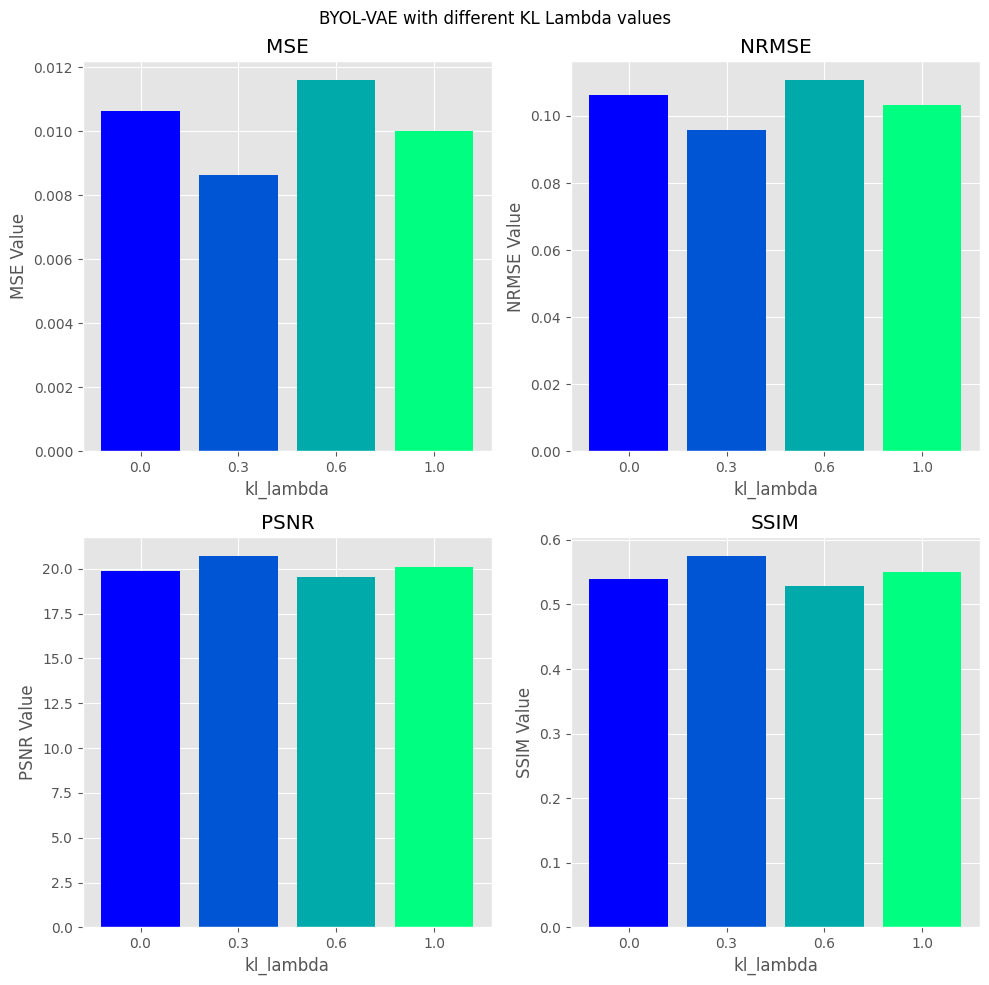

In [ ]:
kl_lambda_results = kl_lambda_results.set_index('kl_lambda')
kl_lambda_results.index = kl_lambda_results.index.astype(str)

colors = cm.winter(np.linspace(0, 1, len(kl_lambda_results.index)))
plt.style.use('ggplot')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].bar(kl_lambda_results.index, kl_lambda_results['MSE'], color=colors)
axs[0, 0].set_title('MSE')
axs[0, 0].set_xlabel('kl_lambda')
axs[0, 0].set_ylabel('MSE Value')

axs[0, 1].bar(kl_lambda_results.index, kl_lambda_results['NRMSE'], color=colors)
axs[0, 1].set_title('NRMSE')
axs[0, 1].set_xlabel('kl_lambda')
axs[0, 1].set_ylabel('NRMSE Value')

axs[1, 0].bar(kl_lambda_results.index, kl_lambda_results['PSNR'], color=colors)
axs[1, 0].set_title('PSNR')
axs[1, 0].set_xlabel('kl_lambda')
axs[1, 0].set_ylabel('PSNR Value')

axs[1, 1].bar(kl_lambda_results.index, kl_lambda_results['SSIM'], color=colors)
axs[1, 1].set_title('SSIM')
axs[1, 1].set_xlabel('kl_lambda')
axs[1, 1].set_ylabel('SSIM Value')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('BYOL-VAE with different KL Lambda values')
plt.tight_layout()
plt.show()

### VAE - BYOL - VAE

In [ ]:
def train_vbv(byol_epochs: int, vae_epochs: int, kl_lambda: float, latent_dim: int) -> pd.DataFrame:
    """
    Train the BYOL and VAE models and evaluate the results.

    Parameters
    ----------
    byol_epochs : int
        Number of epochs to train the BYOL model.
    vae_epochs : int
        Number of epochs to train the VAE model.
    kl_lambda : float
        Weight for the KL divergence loss in the VAE model.
    latent_dim : int
        Dimensionality of the latent space in the VAE model.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the mean evaluation metrics for the trained VAE model.

    """
    encoder = VAEEncoder(latent_dim=latent_dim).to(device)

    vae = VariationalAutoencoder(encoder, latent_dim=latent_dim).to(device)
    vae_trainer = VAETrainer(vae, lr=1e-3)

    trainer_vae1 = pl.Trainer(
        accelerator=device.type,
        max_epochs=int(vae_epochs//3),
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    print(f"VAE-1 training with {vae_epochs//3} epochs")
    trainer_vae1.fit(vae_trainer, train_loader, val_loader)

    byol = BYOL(encoder, latent_channels=latent_dim, learning_rate=1e-4, tau=0.99, lambda_kl=kl_lambda,
                out_channels=latent_dim)
    print(f"Byol training with {byol_epochs} epochs and kl_lambda={kl_lambda}")
    byol_trainer = pl.Trainer(
        accelerator=device.type,
        max_epochs=byol_epochs,
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    byol_trainer.fit(byol, train_loader, val_loader)


    trainer_vae2 = pl.Trainer(
        accelerator=device.type,
        max_epochs=int((2*vae_epochs) // 3),
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )
    print(f"VAE-2 training with {2*vae_epochs//3} epochs")
    trainer_vae2.fit(vae_trainer, train_loader, val_loader)

    metrics = evaluate(vae_trainer, test_loader)

    results = metrics.describe().loc[["mean"]]
    results['kl_lambda'] = kl_lambda

    return results

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


VAE-1 training with 7 epochs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 2480813.5


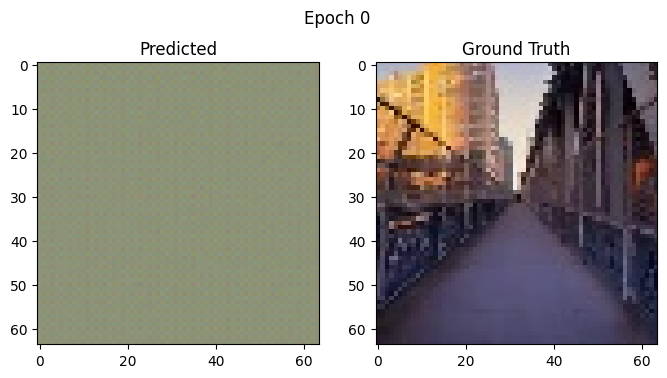

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 379601.5


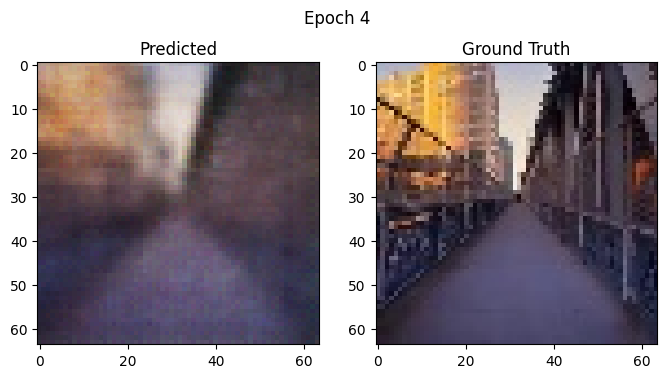

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | online_encoder   | VAEEncoder | 2.2 M  | train
1 | projector        | Sequential | 8.6 K  | train
2 | predictor        | Sequential | 8.4 K  | train
3 | target_encoder   | VAEEncoder | 2.2 M  | eval 
4 | target_projector | Sequential | 8.6 K  | eval 
5 | augmentation     | Sequential | 0      | train
------

Byol training with 10 epochs and kl_lambda=0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val loss in epoch 0: 32244.96484375


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 4: 15.159912109375


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 9: 4.0502214431762695


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


VAE-2 training with 10 epochs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation loss: 1616038.875


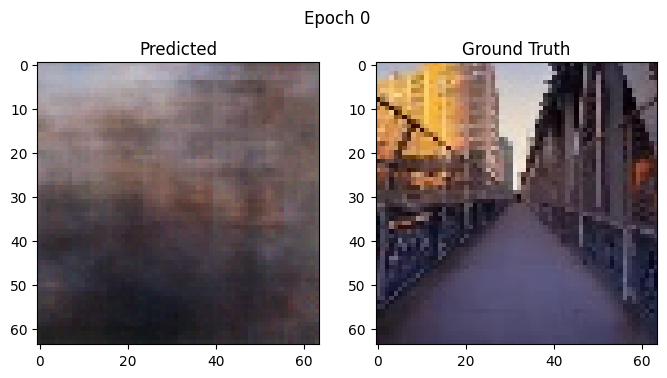

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 334117.75


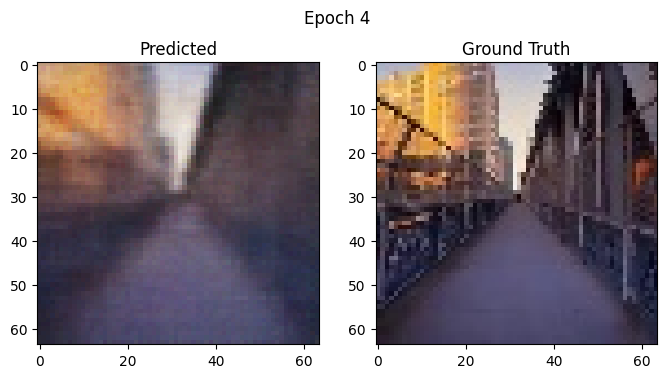

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 287872.40625


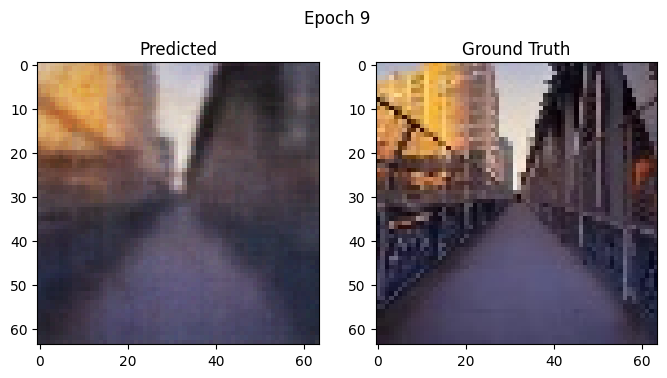

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


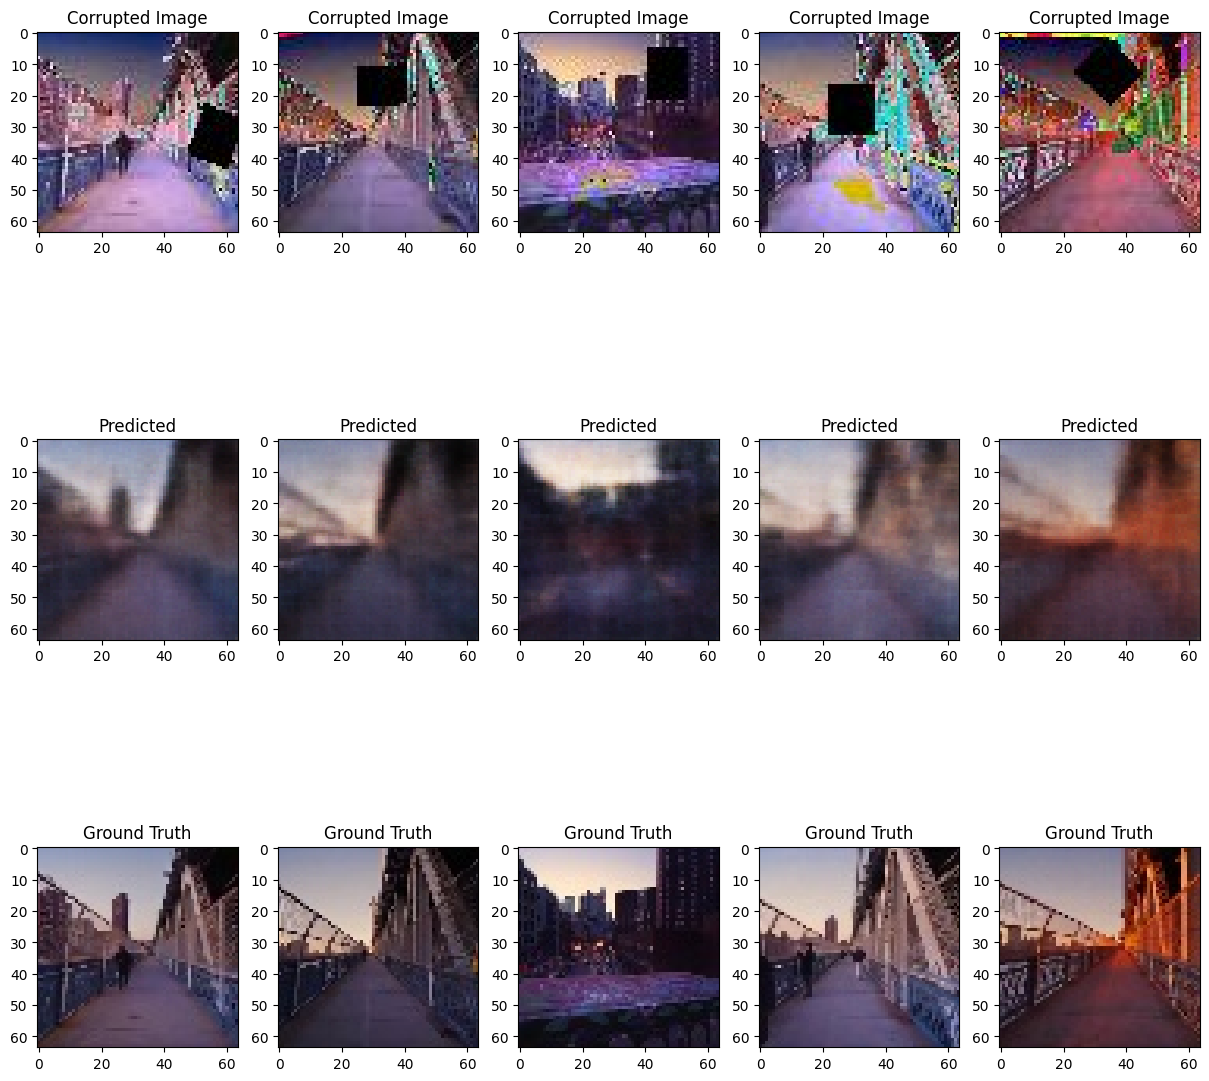

MSE     NRMSE       PSNR      SSIM
max   0.017688  0.136520  27.254297  0.913946
mean  0.007984  0.092181  21.084499  0.592408
min   0.001721  0.043380  17.296080  0.259576

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


VAE-1 training with 7 epochs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 2409293.0


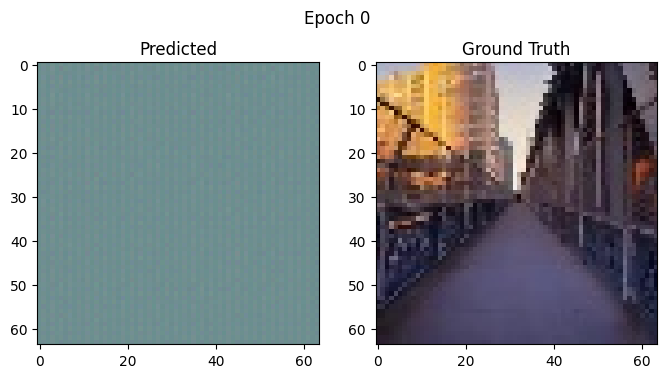

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 376191.75


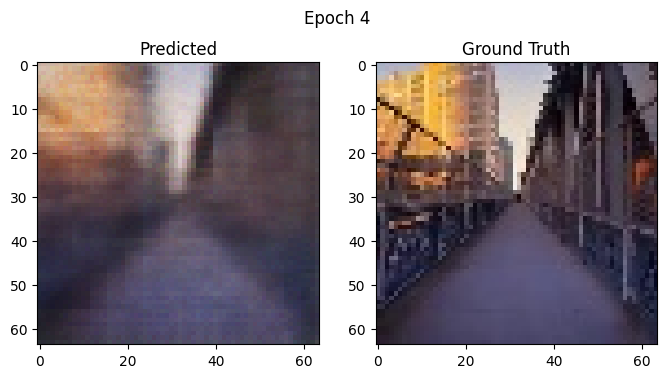

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | online_encoder   | VAEEncoder | 2.2 M  | train
1 | projector        | Sequential | 8.6 K  | train
2 | predictor        | Sequential | 8.4 K  | train
3 | target_encoder   | VAEEncoder | 2.2 M  | eval 
4 | target_projector | Sequential | 8.6 K  | eval 
5 | augmentation     | Sequential | 0      | train
------

Byol training with 10 epochs and kl_lambda=0.3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val loss in epoch 0: 31330.373046875


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 4: 12.797821998596191


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 9: 3.034785509109497


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


VAE-2 training with 10 epochs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation loss: 1861766.75


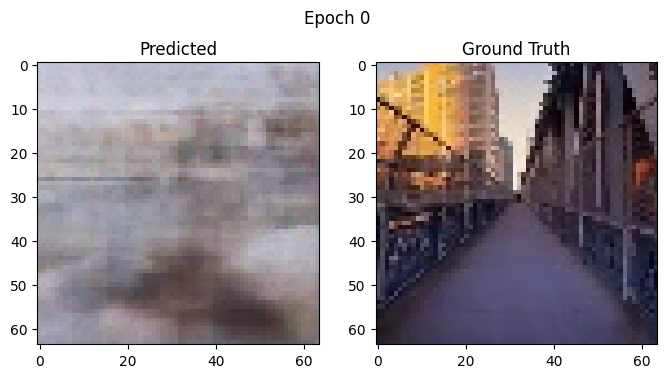

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 317670.96875


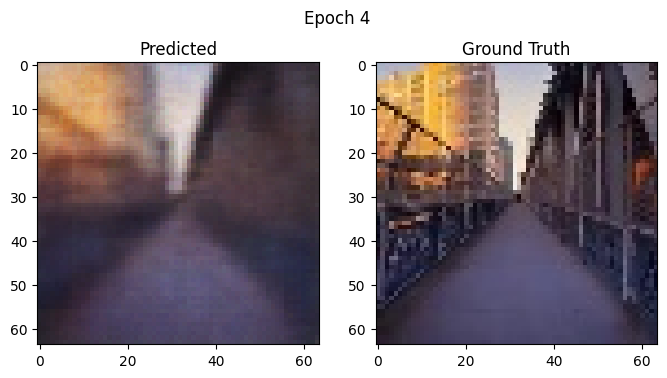

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 283710.09375


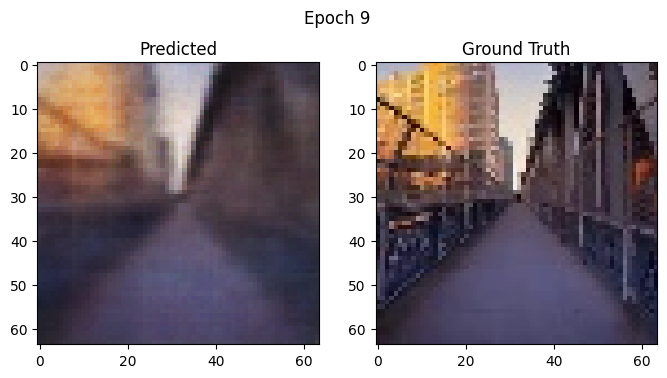

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


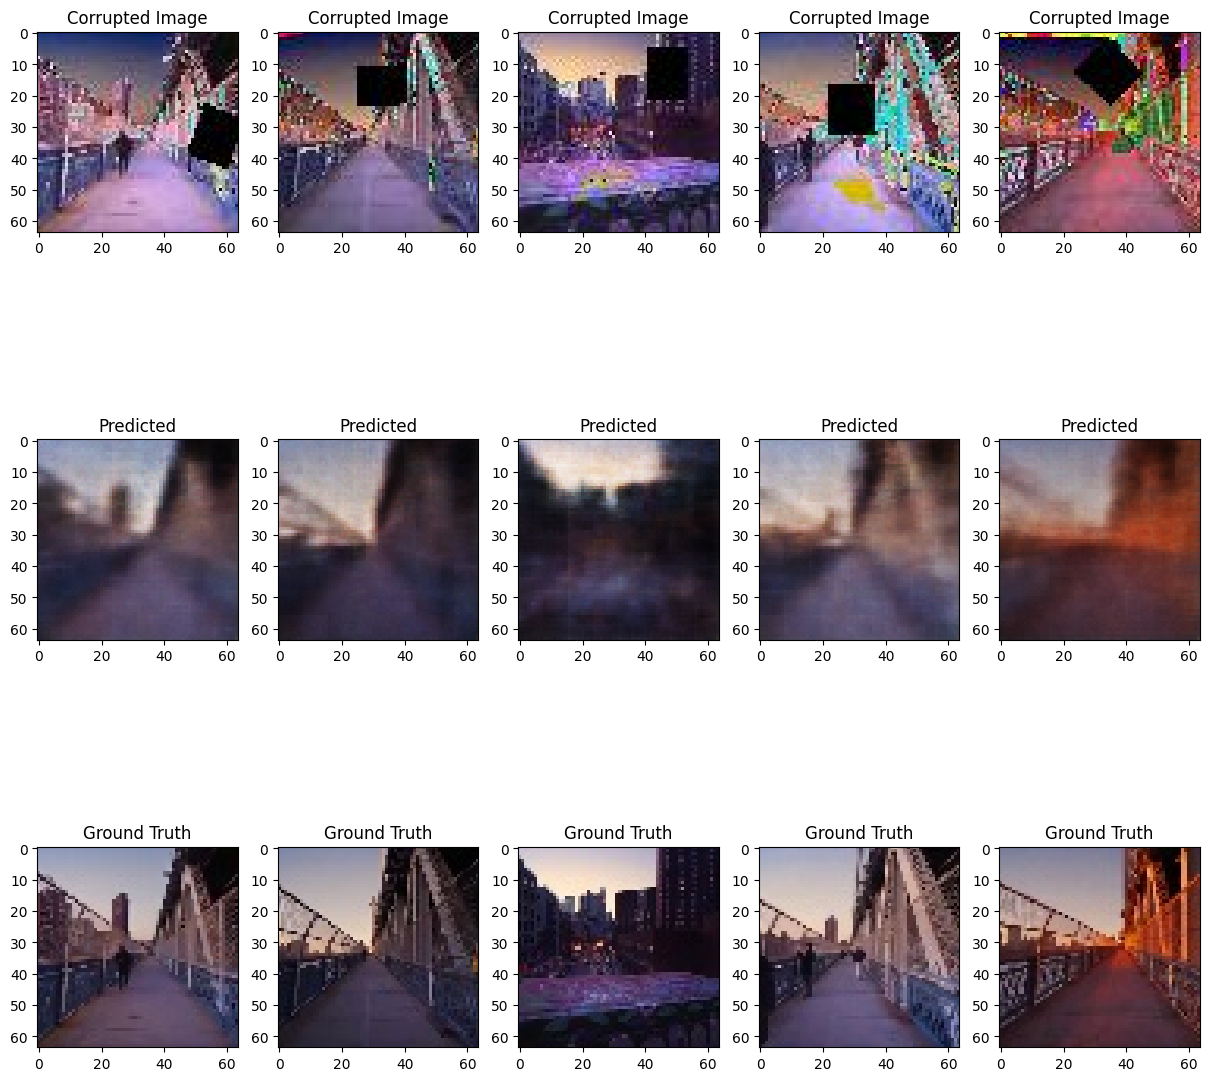

MSE     NRMSE       PSNR      SSIM
max   0.017696  0.142905  26.501716  0.902187
mean  0.008210  0.093316  20.963501  0.586802
min   0.002019  0.047306  16.899022  0.290911

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


VAE-1 training with 7 epochs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 1847457.5


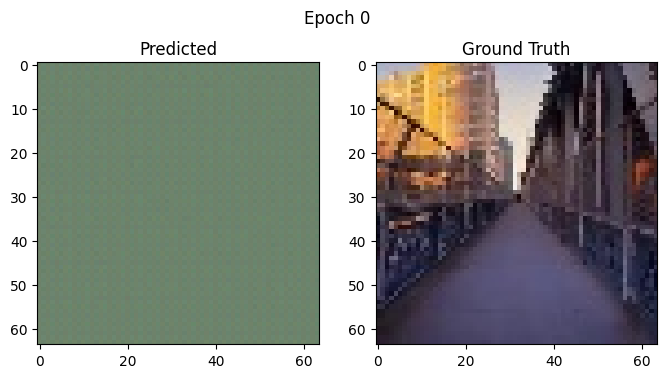

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 375420.6875


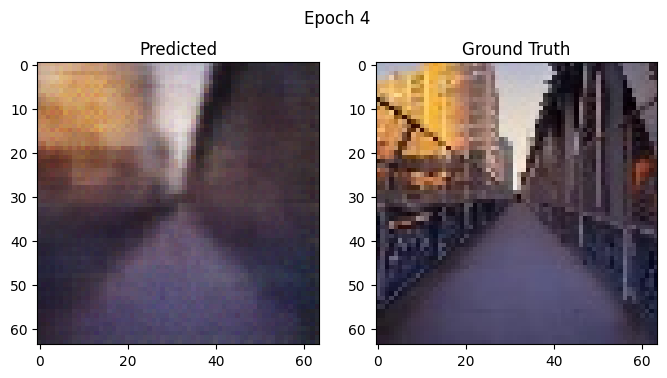

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | online_encoder   | VAEEncoder | 2.2 M  | train
1 | projector        | Sequential | 8.6 K  | train
2 | predictor        | Sequential | 8.4 K  | train
3 | target_encoder   | VAEEncoder | 2.2 M  | eval 
4 | target_projector | Sequential | 8.6 K  | eval 
5 | augmentation     | Sequential | 0      | train
------

Byol training with 10 epochs and kl_lambda=0.6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val loss in epoch 0: 32342.41015625


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 4: 12.284820556640625


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 9: 3.022578001022339


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


VAE-2 training with 10 epochs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation loss: 1816904.75


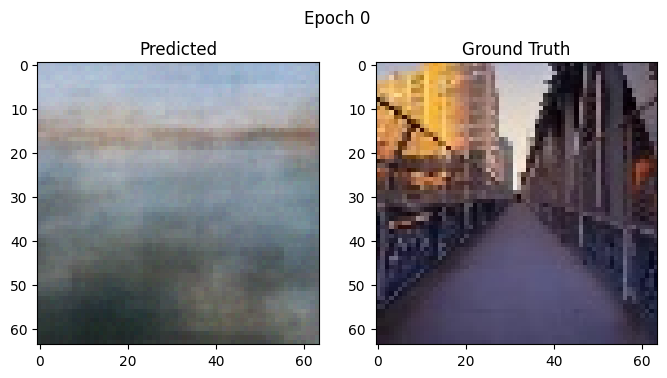

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 325907.71875


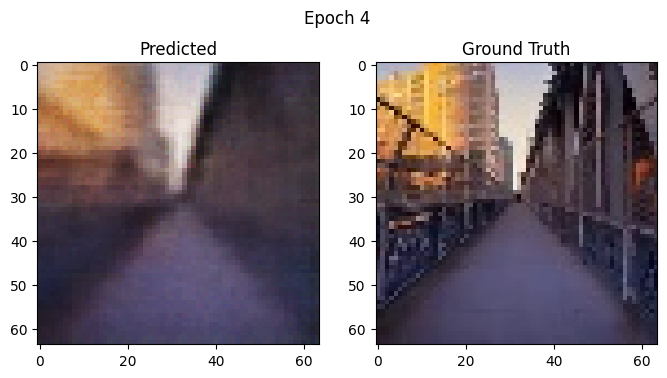

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 289593.65625


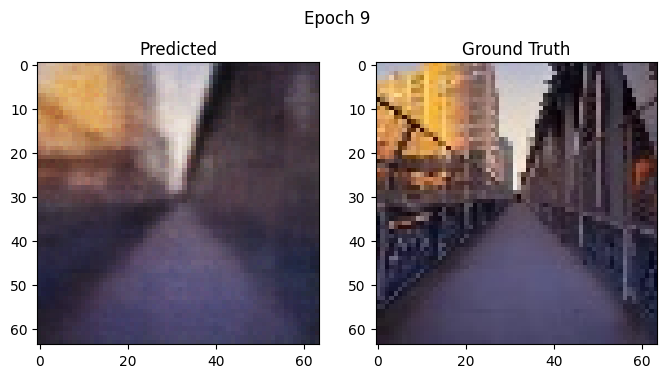

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


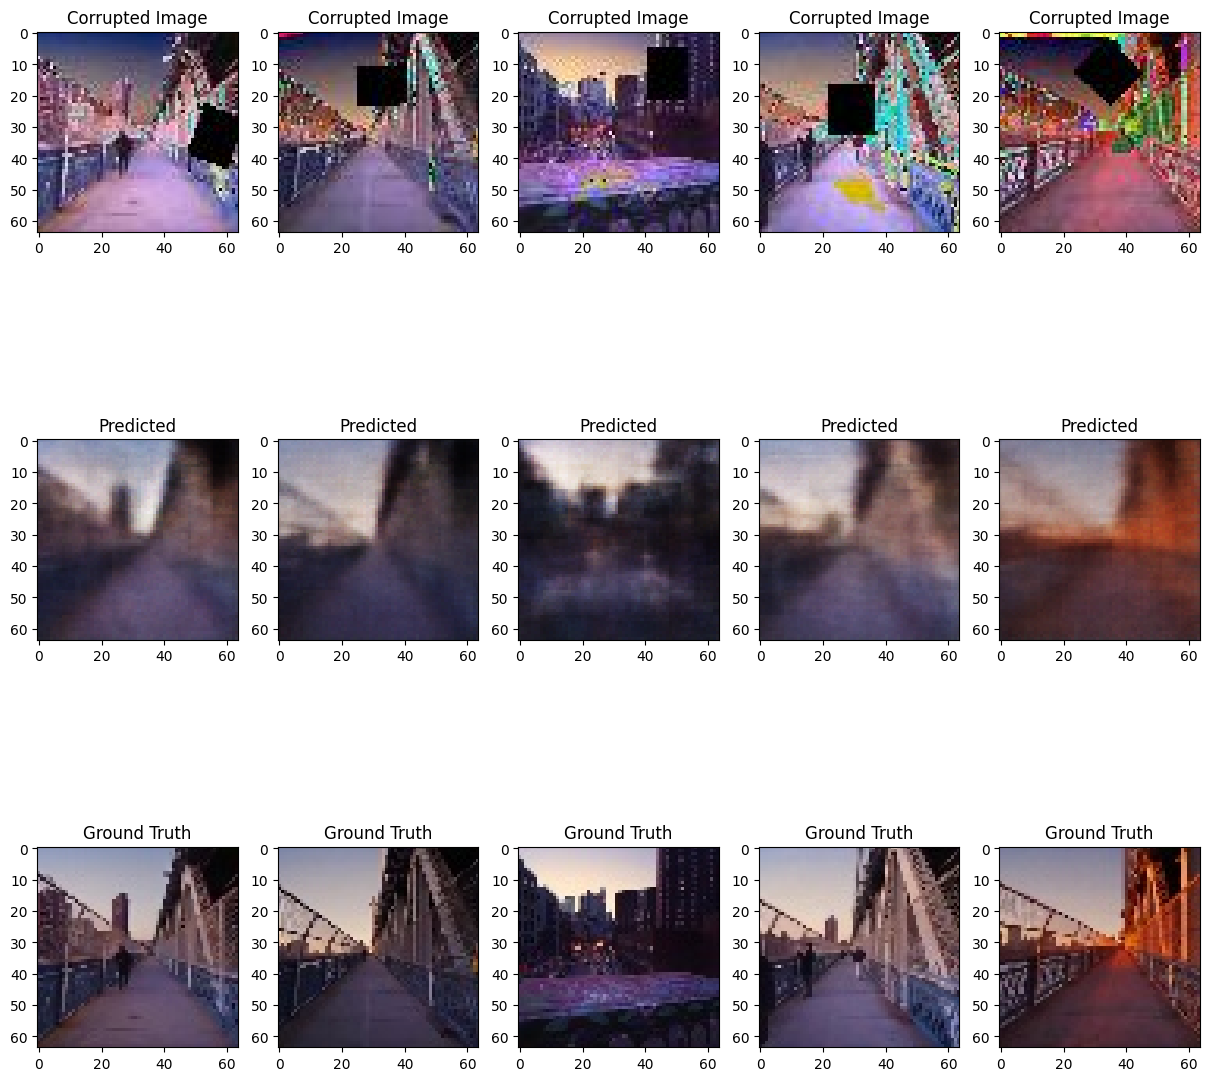

MSE     NRMSE       PSNR      SSIM
max   0.018192  0.141133  26.471954  0.900851
mean  0.008387  0.094711  20.815051  0.585071
min   0.001973  0.047468  17.007448  0.295211

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


VAE-1 training with 7 epochs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 2117054.0


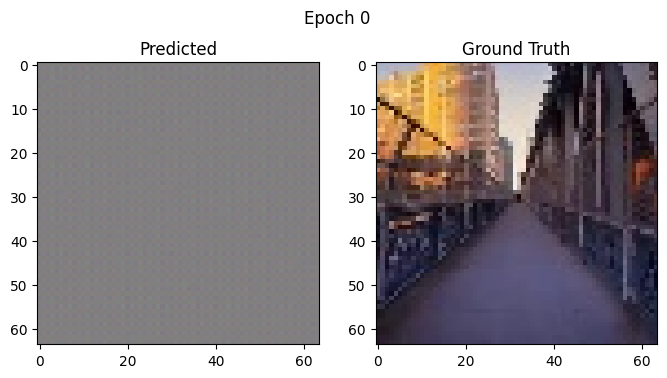

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 410510.03125


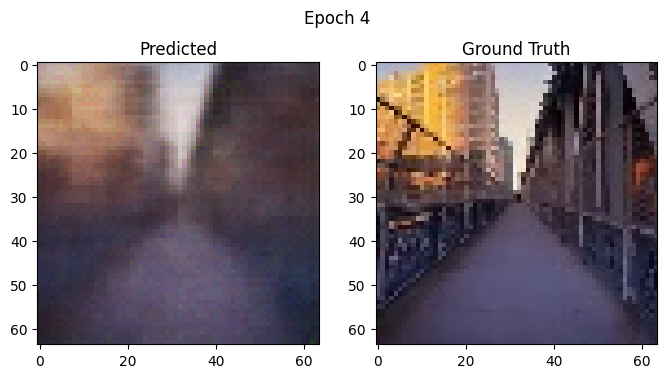

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | online_encoder   | VAEEncoder | 2.2 M  | train
1 | projector        | Sequential | 8.6 K  | train
2 | predictor        | Sequential | 8.4 K  | train
3 | target_encoder   | VAEEncoder | 2.2 M  | eval 
4 | target_projector | Sequential | 8.6 K  | eval 
5 | augmentation     | Sequential | 0      | train
------

Byol training with 10 epochs and kl_lambda=1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val loss in epoch 0: 30392.81640625


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 4: 12.640885353088379


Validation: |          | 0/? [00:00<?, ?it/s]

Val loss in epoch 9: 2.646918296813965


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 4.4 M  | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.757    Total estimated model params size (MB)


VAE-2 training with 10 epochs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation loss: 1686680.75


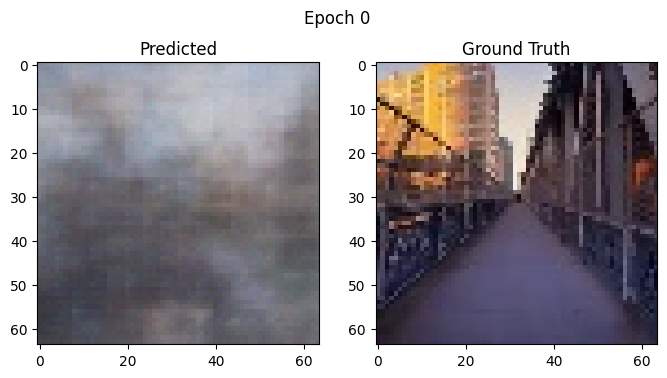

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 342826.375


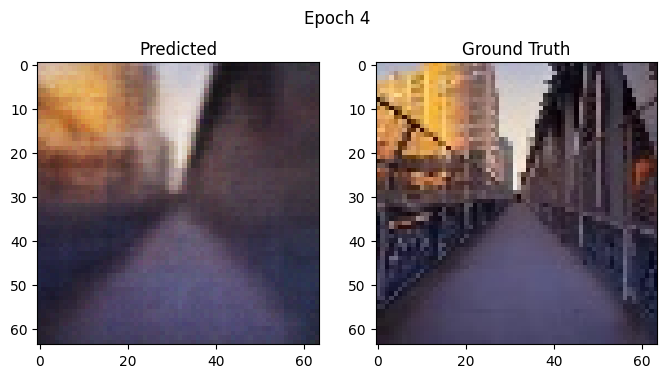

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 309150.78125


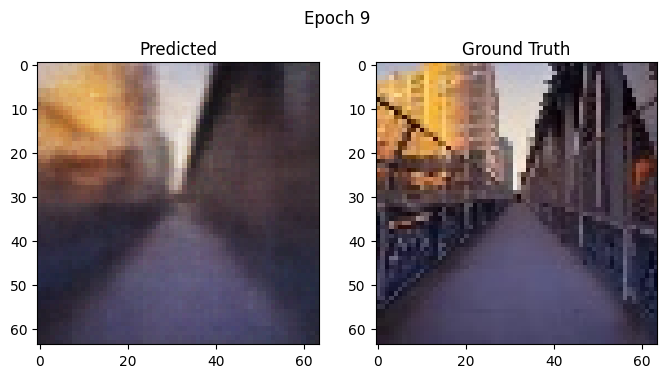

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


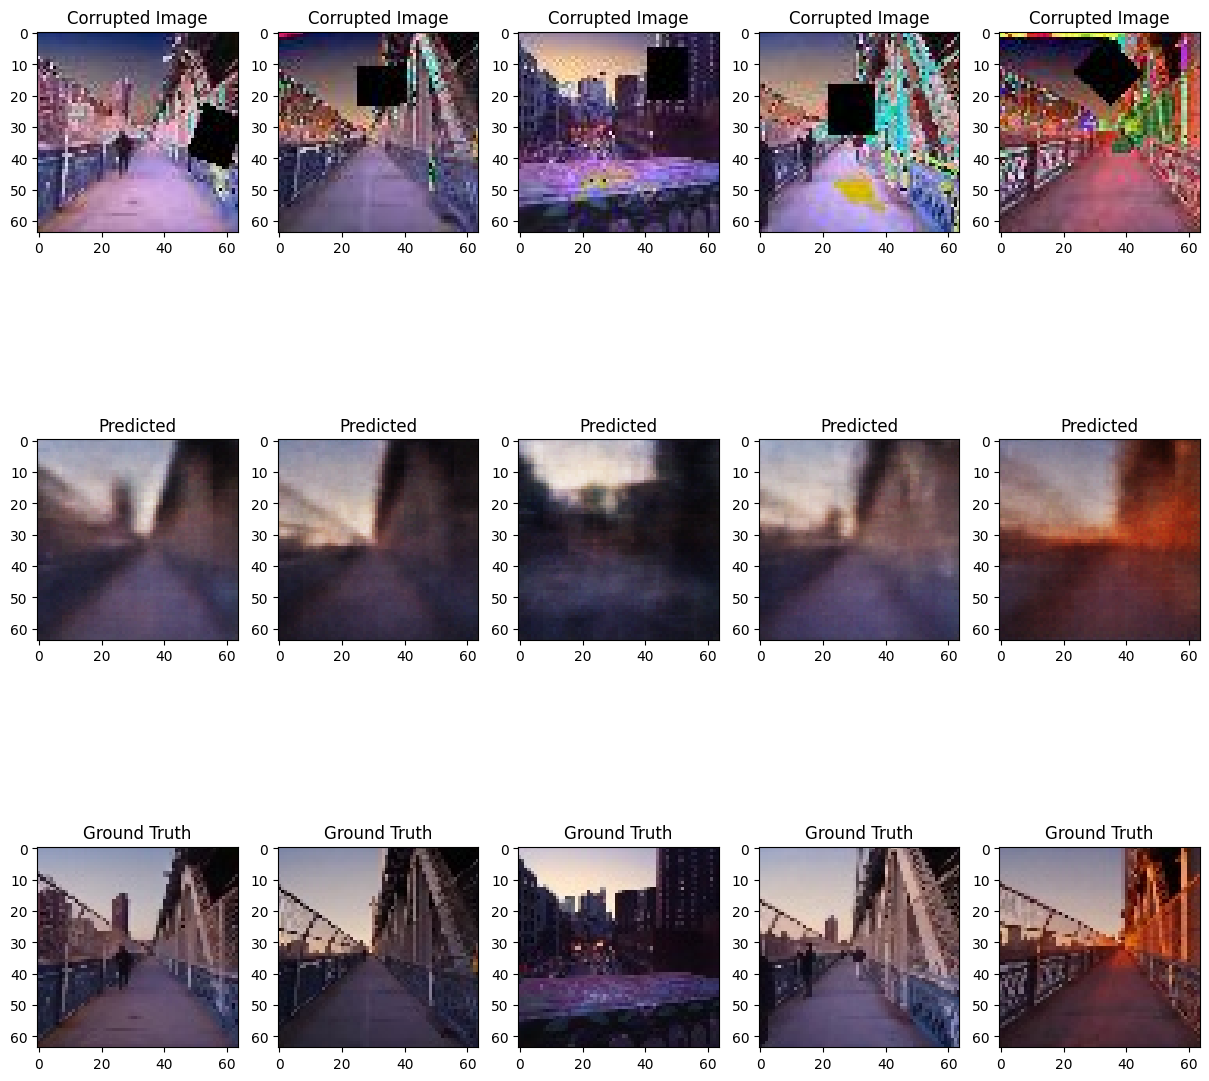

MSE     NRMSE       PSNR      SSIM
max   0.017849  0.149515  26.955989  0.908392
mean  0.008445  0.094486  20.895213  0.587553
min   0.001821  0.044895  16.506279  0.236662

In [ ]:
kl_lambdas = [0, 0.3, 0.6, 1]
kl_lambda_vbv_results = pd.DataFrame()

for kl_lambda in kl_lambdas:
    res = train_vbv(10, 15, kl_lambda, 64)
    kl_lambda_vbv_results = pd.concat([kl_lambda_vbv_results, res], ignore_index=True)

In [ ]:
display(kl_lambda_vbv_results)

MSE     NRMSE       PSNR      SSIM  kl_lambda
0  0.007984  0.092181  21.084499  0.592408        0.0
1  0.008210  0.093316  20.963501  0.586802        0.3
2  0.008387  0.094711  20.815051  0.585071        0.6
3  0.008445  0.094486  20.895213  0.587553        1.0

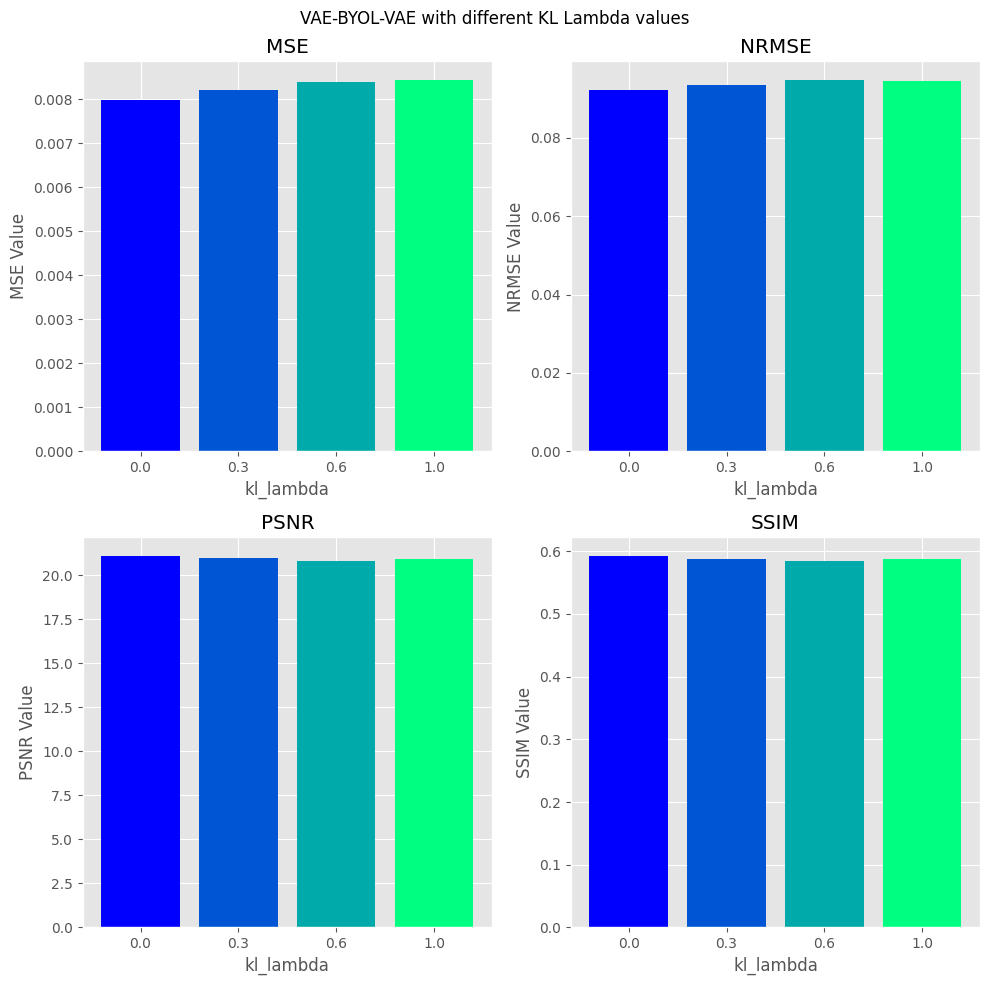

In [ ]:
kl_lambda_vbv_results = kl_lambda_vbv_results.set_index('kl_lambda')
kl_lambda_vbv_results.index = kl_lambda_vbv_results.index.astype(str)

colors = cm.winter(np.linspace(0, 1, len(kl_lambda_vbv_results.index)))

plt.style.use('ggplot')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].bar(kl_lambda_vbv_results.index, kl_lambda_vbv_results['MSE'], color=colors)
axs[0, 0].set_title('MSE')
axs[0, 0].set_xlabel('kl_lambda')
axs[0, 0].set_ylabel('MSE Value')

axs[0, 1].bar(kl_lambda_vbv_results.index, kl_lambda_vbv_results['NRMSE'], color=colors)
axs[0, 1].set_title('NRMSE')
axs[0, 1].set_xlabel('kl_lambda')
axs[0, 1].set_ylabel('NRMSE Value')

axs[1, 0].bar(kl_lambda_vbv_results.index, kl_lambda_vbv_results['PSNR'], color=colors)
axs[1, 0].set_title('PSNR')
axs[1, 0].set_xlabel('kl_lambda')
axs[1, 0].set_ylabel('PSNR Value')

axs[1, 1].bar(kl_lambda_vbv_results.index, kl_lambda_vbv_results['SSIM'], color=colors)
axs[1, 1].set_title('SSIM')
axs[1, 1].set_xlabel('kl_lambda')
axs[1, 1].set_ylabel('SSIM Value')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('VAE-BYOL-VAE with different KL Lambda values')
plt.tight_layout()
plt.show()

## Results and Conclusions


### Wstęp

W celu zbadania postawionej hipotezy sprawdzone zostały dwa podejścia: `BYOL-VAE` oraz `VAE-BYOL-VAE`. Pierwsza z nich polegała na wyuczeniu *enkodera* za pomocą metody `BYOL` przez 15 epok, a następnie wyuczeniu całego modelu `VAE` przez 30 epok. Druga metoda polegała na uwarunkowaniu enkoder na zadaniu inpaintingu z wykorzystaniem modelu `VAE` przez 10 epok, następnie douczeniu jego reprezentacji za pomocą metody `BYOL` i ostatecznie douczeniu całego modelu `VAE` przez kolejne 20 epok. Dla porównania wyuczono także podstawowe `VAE` przez 30 epok, jako punkt odniesienia.


### Wynik hipotezy badawczej

**Hipoteza:** Zastosowanie metody `Bootstrap Your Own Latent (BYOL)` do treningu enkodera modelu `Variational Autoencoder (VAE)` doprowadzi do poprawy jego wydajności w zadaniu inpaintingu obrazów.

Jak wynika z badań, można jednoznacznie stwierdzić, że metoda `BYOL` nie poprawia wyników modleu `VAE` dla zadaniu inpainingu, a nawet wręcz potrafi je pogorszyć. Z wyników jednoznacznie wynika, że podstawowy model `VAE` osiąga lepsze rezultaty od jego modyfikacji.

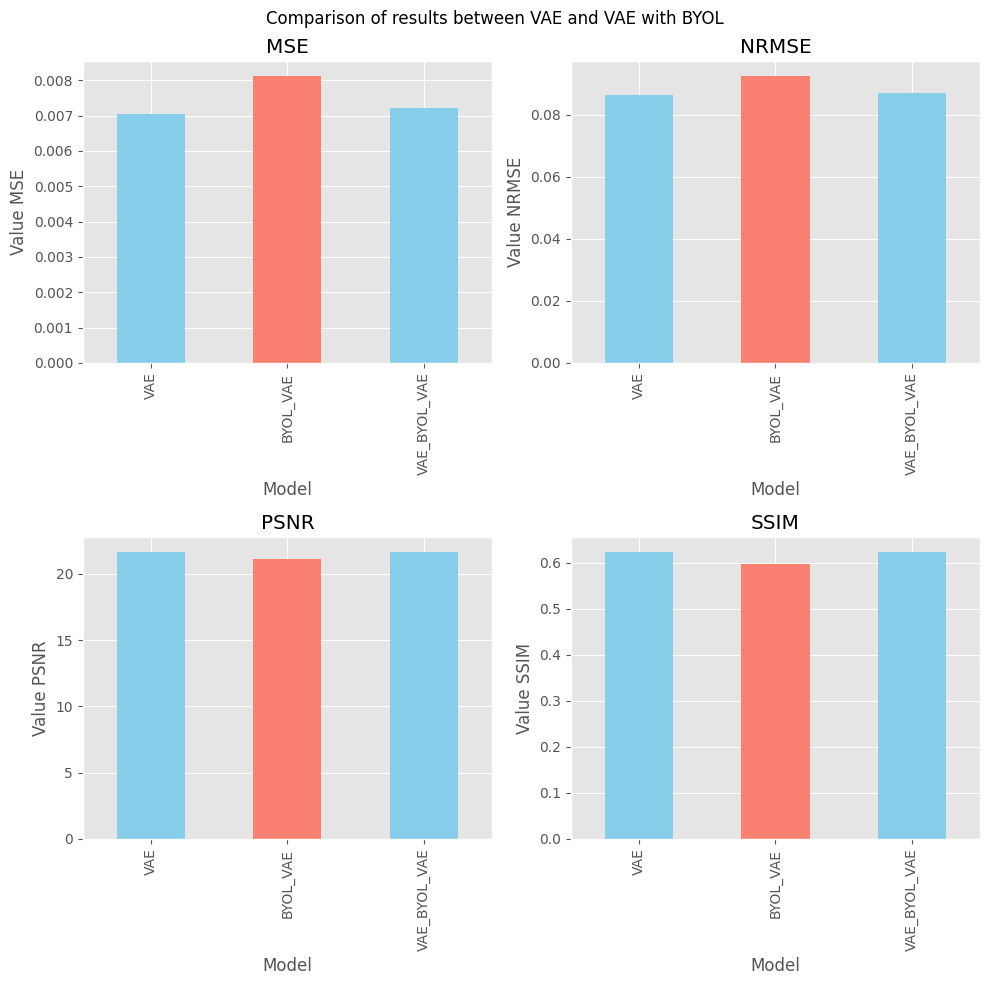


### Wyniki Eksperymentu

W zadaniu przepadany został wpływ hiperparametru `lambda_kl` na efektywność uczenia się metody `BYOL`. Oba z porponoponowanych podejść `BYOL-VAE` oraz `VAE-BYOL-VAE` uczone były dla 4 wartośći parametru {0, 0.3, 0.6, 1}. Proces uczenia trwał 15 epok modelu `VAE` (w drugiej konfiguracji w stosunku 1:2) oraz 10 epok modelu `BYOL`.

Na podsatwie wynikó badania można stwierdzić, że parametr `lambda_kl` nie posiada tak dużego wpływu na wyniki jak zakładano początkowo. Dla podejścia `BYOL-VAE` najlepsza okazała się wartość parametru równa 0.3 i była ona zauważalnie lepsza od pozostałych. DLa podejścia `VAE-BYOL-VAE` najlepsza okazała się wartość 0, jednakże jej wyniki były bardzo zbliżone do wyników innych wartości.

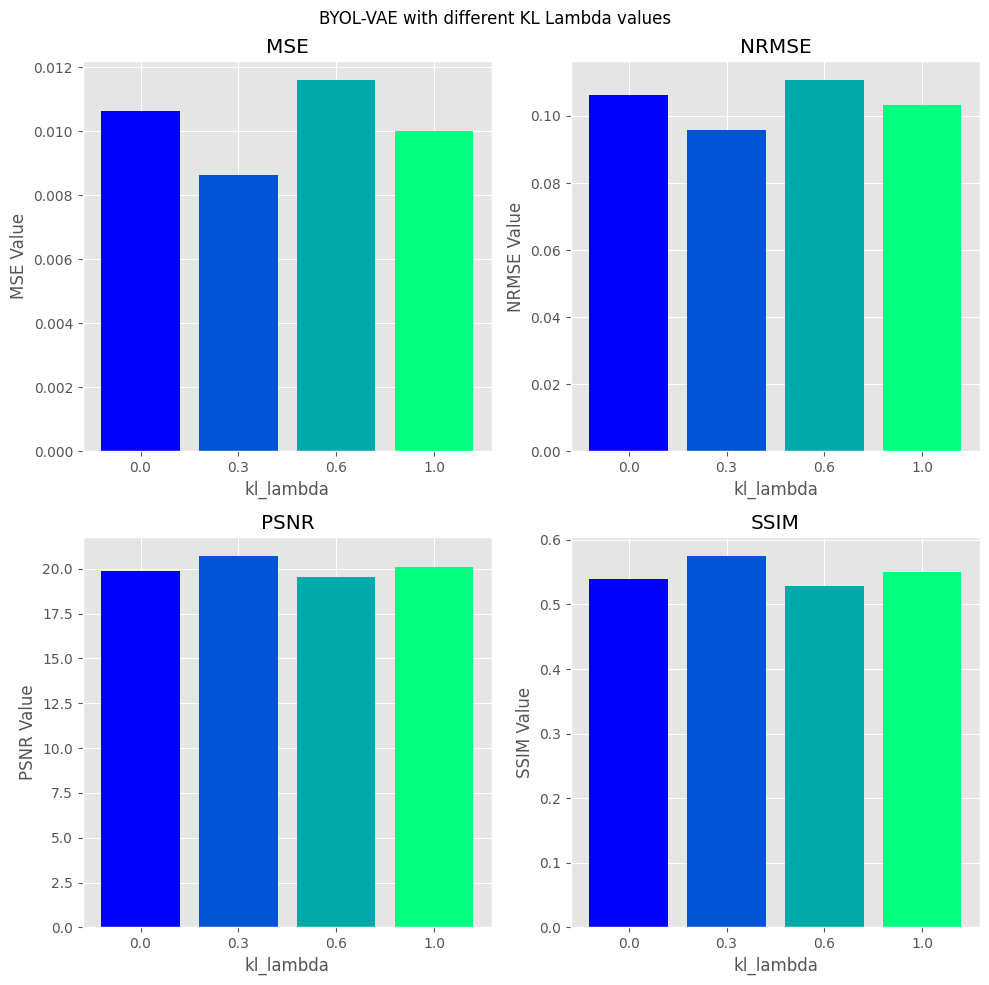

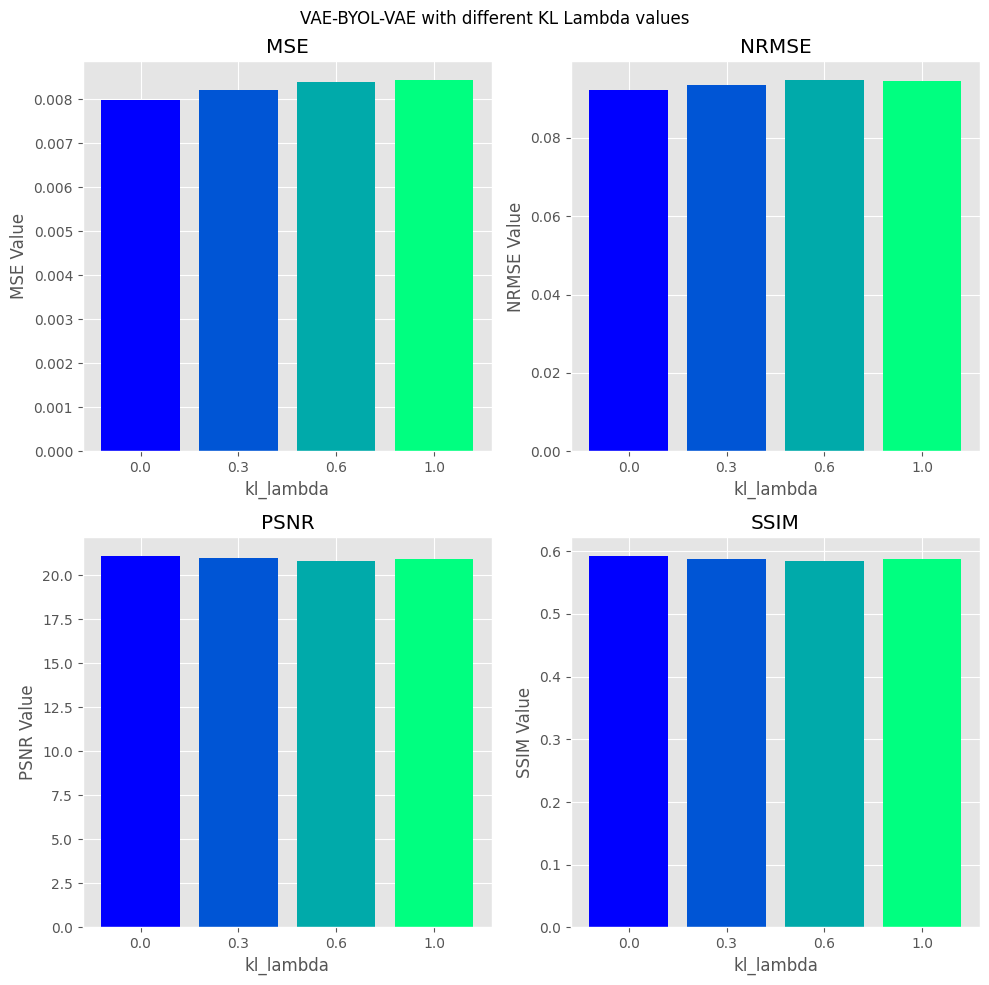